# Notebook to evaluate the dependence of colors with atmospheric parameters and to compute color corrections 

In this notebook, we are going to evaluate the dependence of the colors with the atmospheric parameters and the spectral types. We will see if this classification is good or if we should use any alternative. 

# Load necessary packages 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pysynphot as S
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import chi2
from scipy.integrate import quad
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.utils.exceptions import AstropyUserWarning
import warnings

# allow interactive plots
%matplotlib widget

In [2]:
input_dir = 'output_files/'

Files with atmospheric parameters, colours and errors 

In [3]:
atm_file = 'atm_vals_{0}_airmass_{1}_cloud_{2}.npy'

In [4]:
color_file = 'colour_dict_varying_{0}_airmass_{1:.1f}_cloud_{2}.npy'
color_ref_file = 'colour_dict_varying_{0}_airmass_{1:.1f}_cloud_{2}_ref.npy'

sn_color_file = 'sn_colour_dict_varying_{0}_airmass_{1:.1f}_cloud_{2}.npy'
sn_color_ref_file = 'sn_colour_dict_varying_{0}_airmass_{1:.1f}_cloud_{2}_ref.npy'

In [5]:
color_err_file = 'colour_err_dict_varying_{0}_airmass_{1:.1f}_cloud_{2}.npy'
color_err_ref_file = 'colour_err_dict_varying_{0}_airmass_{1:.1f}_cloud_{2}_ref.npy'

sn_color_err_file = 'sn_colour_err_dict_varying_{0}_airmass_{1:1.1f}_cloud_{2}.npy'
sn_color_err_ref_file = 'sn_colour_err_dict_varying_{0}_airmass_{1:.1f}_cloud_{2}_ref.npy'

In [6]:
spectral_types = ['O','B','A','F','G','K','M']
type_colors = {'O':'violet','B':'cyan','A':'b','F':'g','G':'y','K':'orange','M':'r'}
type_markers = {'O':'s','B':'x','A':'o','F':'v','G':'^','K':'P','M':'*'}

In [7]:
filters = ['u','g','r','i','z','Y']

In [8]:
colors = []
for i in range(len(filters)-1):
    colors.append('{0}-{1}'.format(filters[i].lower(),filters[i+1].lower()))

# Define functions 

In [9]:
def lin_fun(x,a,b):
    return a*x+b

In [10]:
def quad_fun(x,a,b,c):
    return a*x**2.+b*x+c

In [11]:
def quad_dev(x,a,b):
    return 2.*a*x+b

# Atmospheric parameters information 

In [12]:
atm_params = {'pwv':{'min':1.,'max':9.,'fixed':3.0},
               'aerosol':{'min':0.01,'max':0.09,'fixed':0.04},
               'ozone':{'min':200.,'max':400.,'fixed':300},
               'cloud':{'min':0.0,'max':1.0,'fixed':0.0},
               'airmass':{'min':1.0,'max':1.9,'fixed':1.2},
}

In [13]:
min_airmass = atm_params['airmass']['min']
max_airmass = atm_params['airmass']['max']
am_vals = np.round(np.linspace(min_airmass,max_airmass,10),1)
print(am_vals)

[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9]


# Check dependencies 

In [14]:
am0 = atm_params['airmass']['fixed']
cloud0 = atm_params['cloud']['fixed']
pwv0 = atm_params['pwv']['fixed']
aero0 = atm_params['aerosol']['fixed']
oz0 = atm_params['ozone']['fixed']

We evaluate the dependency between $\Delta c^{xy} = c^{xy}_{obs} - c^{xy}_{std}$ and PWV, aerosols and airmass. Each time we vary one parameter, the rest of them are fixed to the standard values. 

For each star of each spectral type we fit $\Delta c^{xy}$ to a function of the given atmospheric parameter, $f(p)$. Then, we compute the mean model for each spectral type as the average of the fitted models on the individual stars. 

# PWV 

In [15]:
pwv_vals = np.load(os.path.join(input_dir,atm_file.format('pwv',am0,cloud0)),allow_pickle=True).ravel()
print(pwv_vals)

[1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [16]:
pwv_color_dict = np.load(os.path.join(input_dir,color_file.format('pwv',am0,cloud0)),allow_pickle=True).ravel()[0]
pwv_color_ref_dict = np.load(os.path.join(input_dir,color_ref_file).format('pwv',am0,cloud0),allow_pickle=True).ravel()[0]

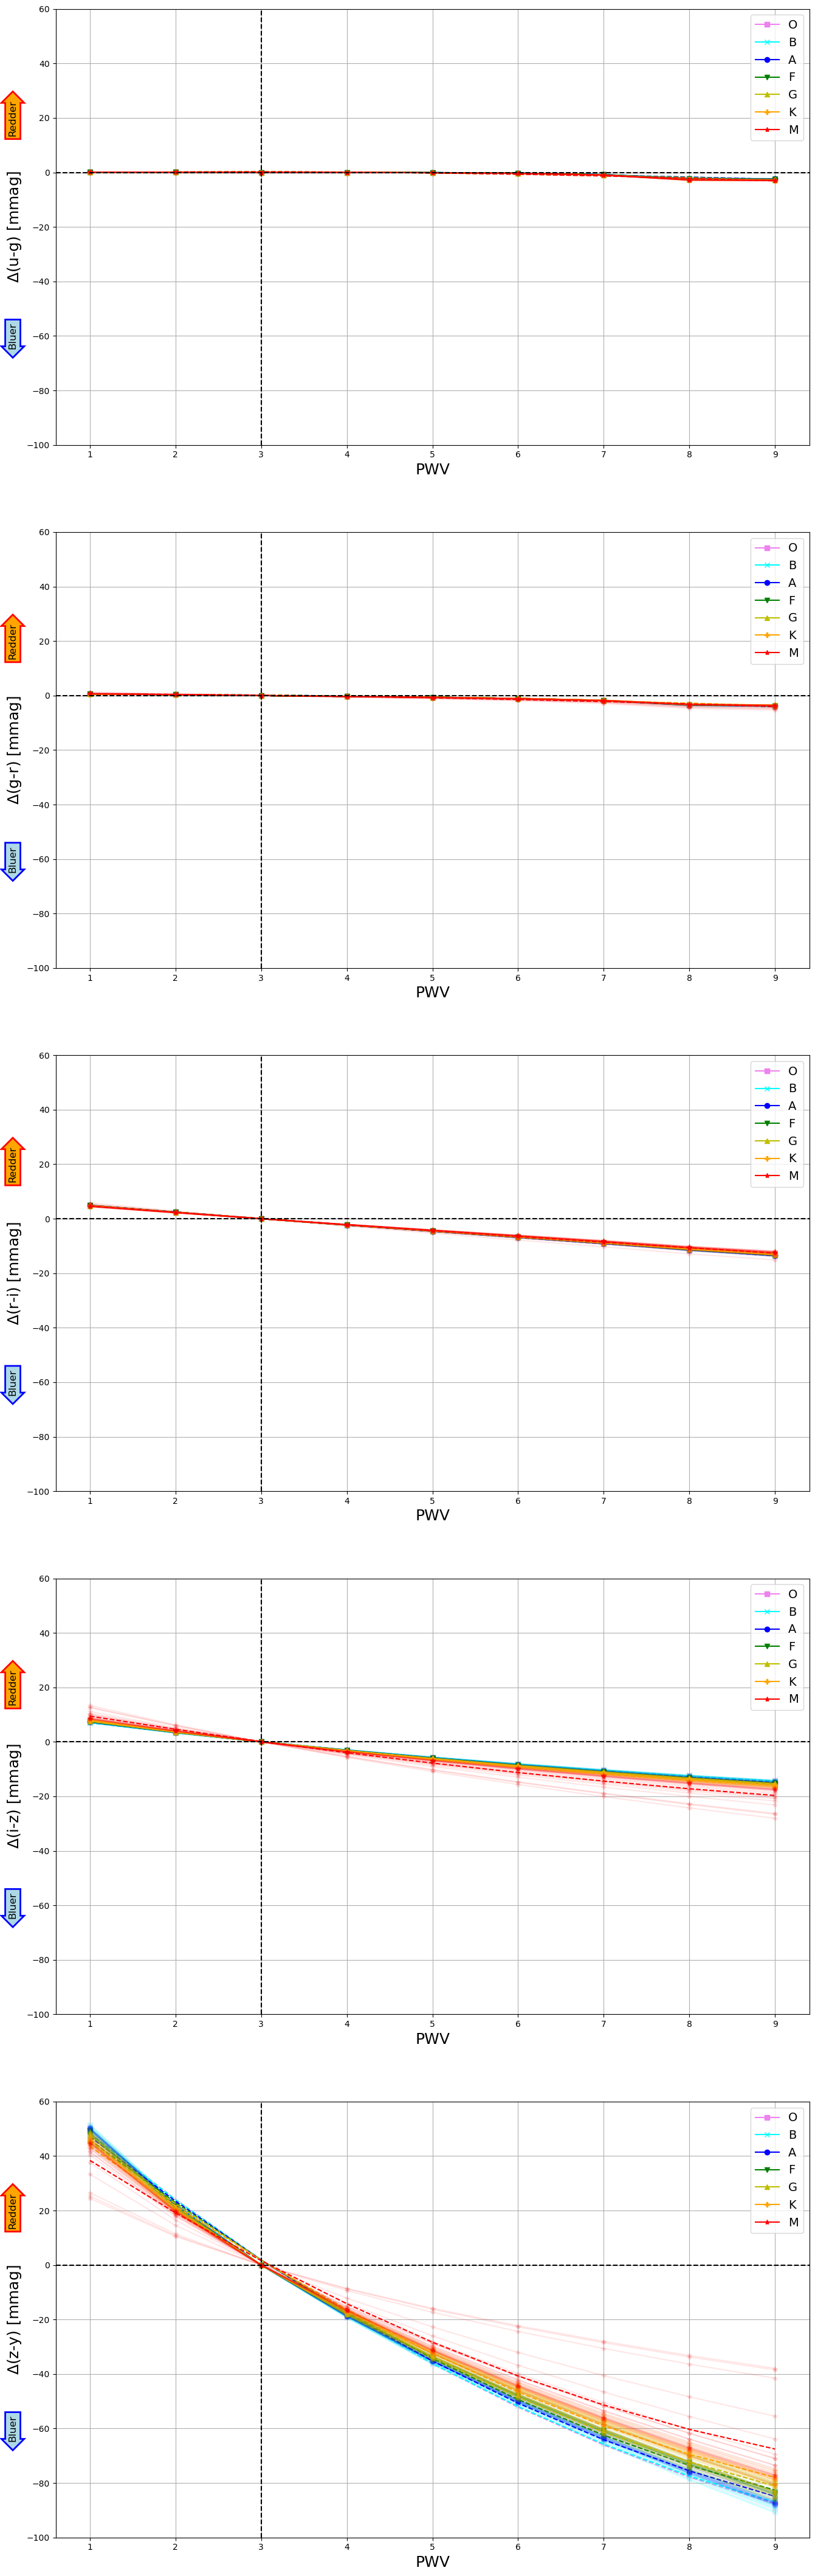

In [17]:
plt.ioff()
fig_rows = len(colors)
fig_cols = 1
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(16,54))

yrange = (-100.,60.)

pwv_model_dict = {}
for row,color in enumerate(colors):
    for spec_type in spectral_types:
        param_list = []
        for si in pwv_color_dict[spec_type]:
            delta_c_ = (pwv_color_dict[spec_type][si][color]-pwv_color_ref_dict[spec_type][si][color])*1000.
            
            p_,cov_ = curve_fit(quad_fun,pwv_vals,delta_c_/1000.)
            param_list.append(p_)
            
            axs[row].plot(pwv_vals,delta_c_,marker=type_markers[spec_type],c=type_colors[spec_type],alpha=0.1)
        param_list = np.array(param_list)
        mean_params_ = np.mean(param_list,axis=0)
        pwv_model_dict[(spec_type,color)] = mean_params_
        
        model_ = quad_fun(pwv_vals,mean_params_[0],mean_params_[1],mean_params_[2])*1000.
        axs[row].plot(pwv_vals,model_,ls='--',marker='',c=type_colors[spec_type])
        axs[row].plot([],[],marker=type_markers[spec_type],c=type_colors[spec_type],label=spec_type)
    axs[row].axhline(y=0.0,ls='--',color='k')
    axs[row].axvline(x=pwv0,ls='--',color='k')
    axs[row].set_ylim(yrange)
    axs[row].grid()
    axs[row].set_xlabel('PWV',fontsize=18)
    axs[row].set_ylabel(r'$\Delta$'+'('+color+') [mmag]',fontsize=18)
    axs[row].text(0.1,-60.,"Bluer",ha="center",va="center",rotation=90.,size=12,
                  bbox=dict(boxstyle="larrow,pad=0.3",fc="lightblue",ec="blue",lw=2))
    axs[row].text(0.1,20.,"Redder",ha="center",va="center",rotation=90.,size=12,
                  bbox=dict(boxstyle="rarrow,pad=0.3",fc="orange",ec="red",lw=2))
    axs[row].legend(loc="best",fontsize=14)
            
    
display(fig)

del fig,axs
plt.ion() 

# Aerosols 

In [18]:
aero_vals = np.load(os.path.join(input_dir,atm_file.format('aerosol',am0,cloud0)),allow_pickle=True).ravel()
print(aero_vals)

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09]


In [19]:
aero_color_dict = np.load(os.path.join(input_dir,color_file.format('aerosol',am0,cloud0)),allow_pickle=True).ravel()[0]
aero_color_ref_dict = np.load(os.path.join(input_dir,color_ref_file).format('aerosol',am0,cloud0),allow_pickle=True).ravel()[0]

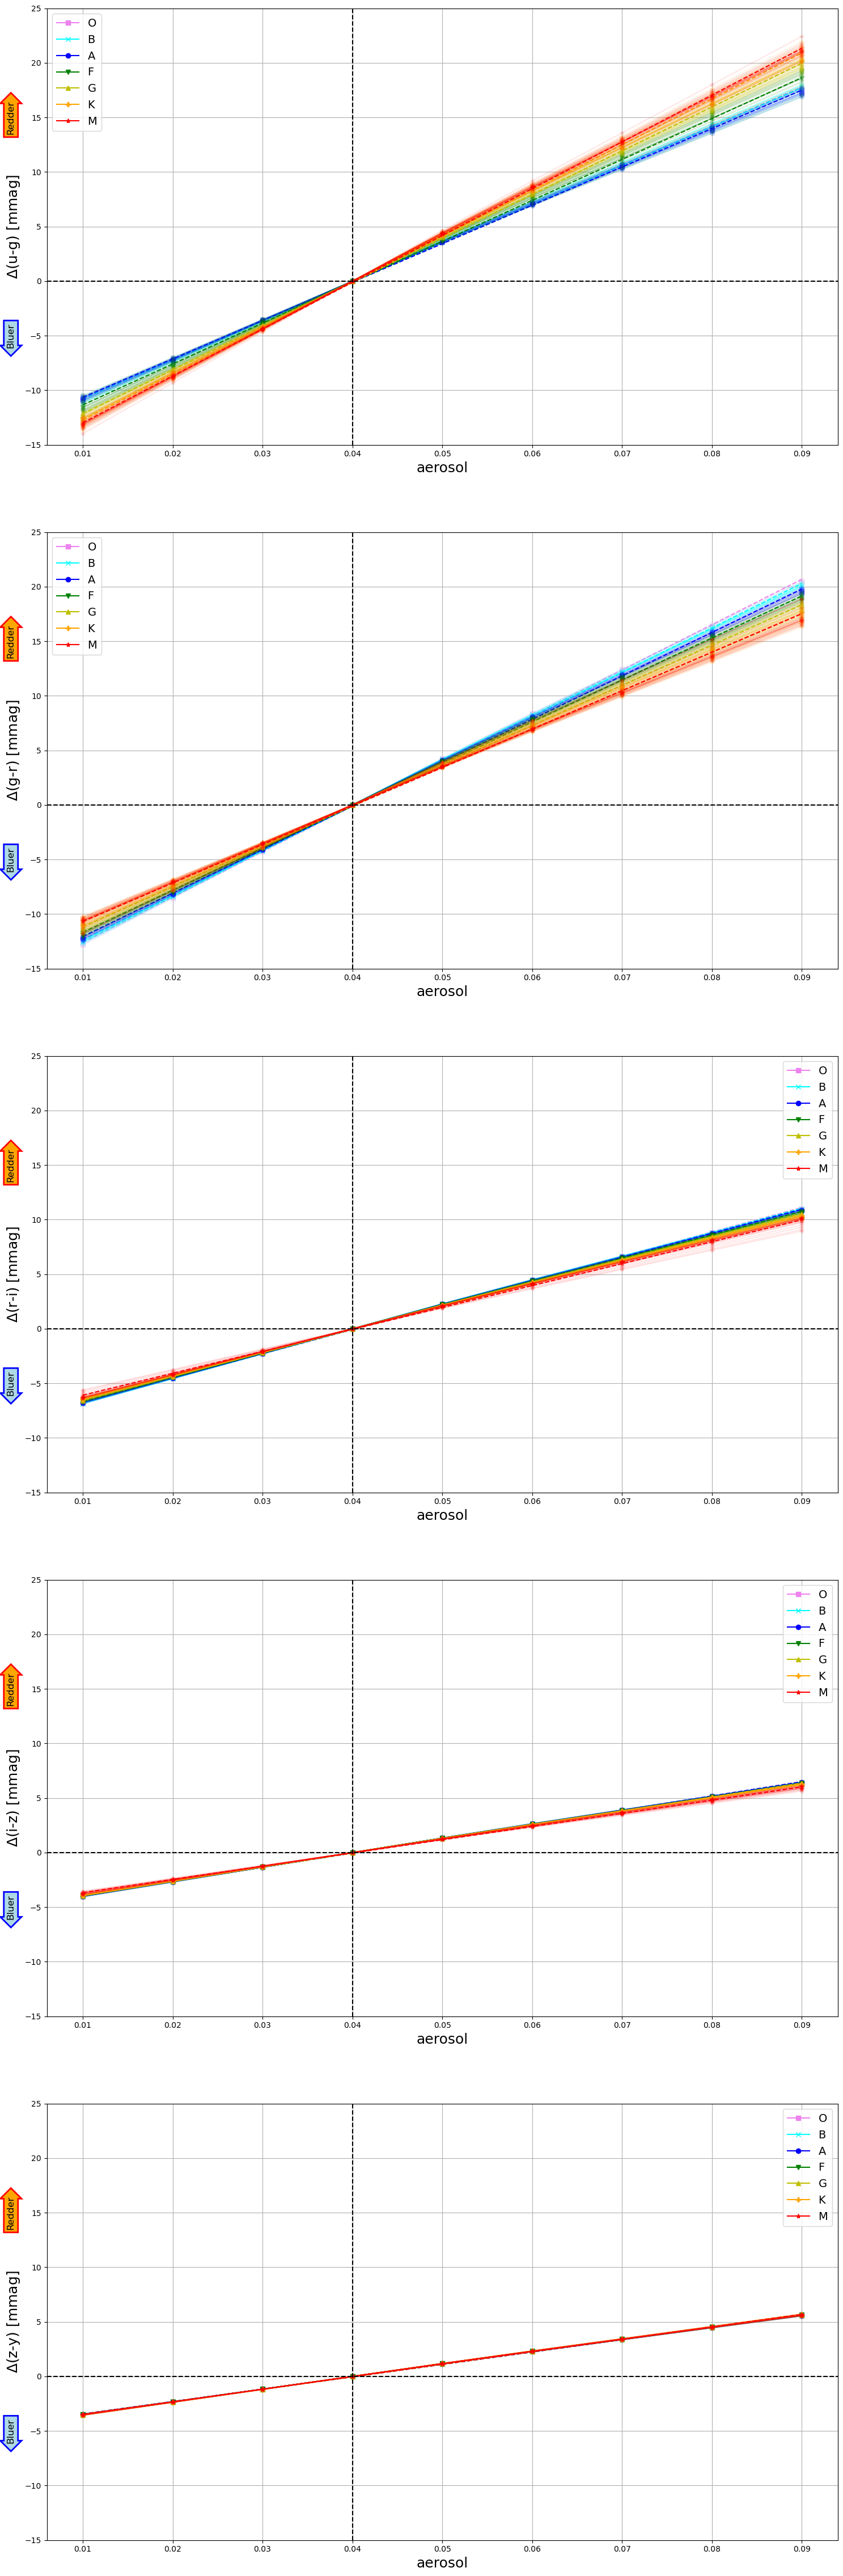

In [20]:
plt.ioff()
fig_rows = len(colors)
fig_cols = 1
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(18,58))

yrange = (-15.,25.)

aero_model_dict = {}
for row,color in enumerate(colors):
    for spec_type in spectral_types:
        param_list = []
        for si in aero_color_dict[spec_type]:
            delta_c_ = (aero_color_dict[spec_type][si][color]-aero_color_ref_dict[spec_type][si][color])*1000.
            
            p_,cov_ = curve_fit(lin_fun,aero_vals,delta_c_/1000.)
            param_list.append(p_)
            
            axs[row].plot(aero_vals,delta_c_,marker=type_markers[spec_type],c=type_colors[spec_type],alpha=0.1)
            
        param_list = np.array(param_list)
        mean_params_ = np.mean(param_list,axis=0)
        aero_model_dict[(spec_type,color)] = mean_params_
        
        model_ = lin_fun(aero_vals,mean_params_[0],mean_params_[1])*1000.
        axs[row].plot(aero_vals,model_,ls='--',marker='',c=type_colors[spec_type])
        axs[row].plot([],[],marker=type_markers[spec_type],c=type_colors[spec_type],label=spec_type)
    axs[row].axhline(y=0.0,ls='--',color='k')
    axs[row].axvline(x=aero0,ls='--',color='k')
    axs[row].set_ylim(yrange)
    axs[row].grid()
    axs[row].set_xlabel('aerosol',fontsize=18)
    axs[row].set_ylabel(r'$\Delta$'+'('+color+') [mmag]',fontsize=18)
    axs[row].text(0.002,-5.,"Bluer",ha="center",va="center",rotation=90.,size=12,
                  bbox=dict(boxstyle="larrow,pad=0.3",fc="lightblue",ec="blue",lw=2))
    axs[row].text(0.002,15.,"Redder",ha="center",va="center",rotation=90.,size=12,
                  bbox=dict(boxstyle="rarrow,pad=0.3",fc="orange",ec="red",lw=2))
    axs[row].legend(loc="best",fontsize=14)
            
    
display(fig)

del fig,axs
plt.ion() 

# Airmass 

In [21]:
ref_param = 'pwv'
am_color_ref_dict = pwv_color_ref_dict

In [22]:
am_color_dict = {}

for spec_type in spectral_types:
    st_dict_ = {}
    for si in am_color_ref_dict[spec_type]:
        si_dict_ = {}
        for color in colors:
            vals_ = []
            for am in am_vals:
                c_dict_ = np.load(os.path.join(input_dir,color_ref_file).format(ref_param,am,cloud0),allow_pickle=True).ravel()[0]
                vals_.append(c_dict_[spec_type][si][color])
            vals_ = np.array(vals_)
            si_dict_[color] = vals_
        st_dict_[si] = si_dict_
    am_color_dict[spec_type] = st_dict_
        
        

In [23]:
am_color_dict['O'][0]['u-g']-am_color_ref_dict['O'][0]['u-g']

array([-0.05523139, -0.02757394,  0.        ,  0.02749149,  0.05490156,
        0.08223111,  0.10948122,  0.1366528 ,  0.16374687,  0.19076444])

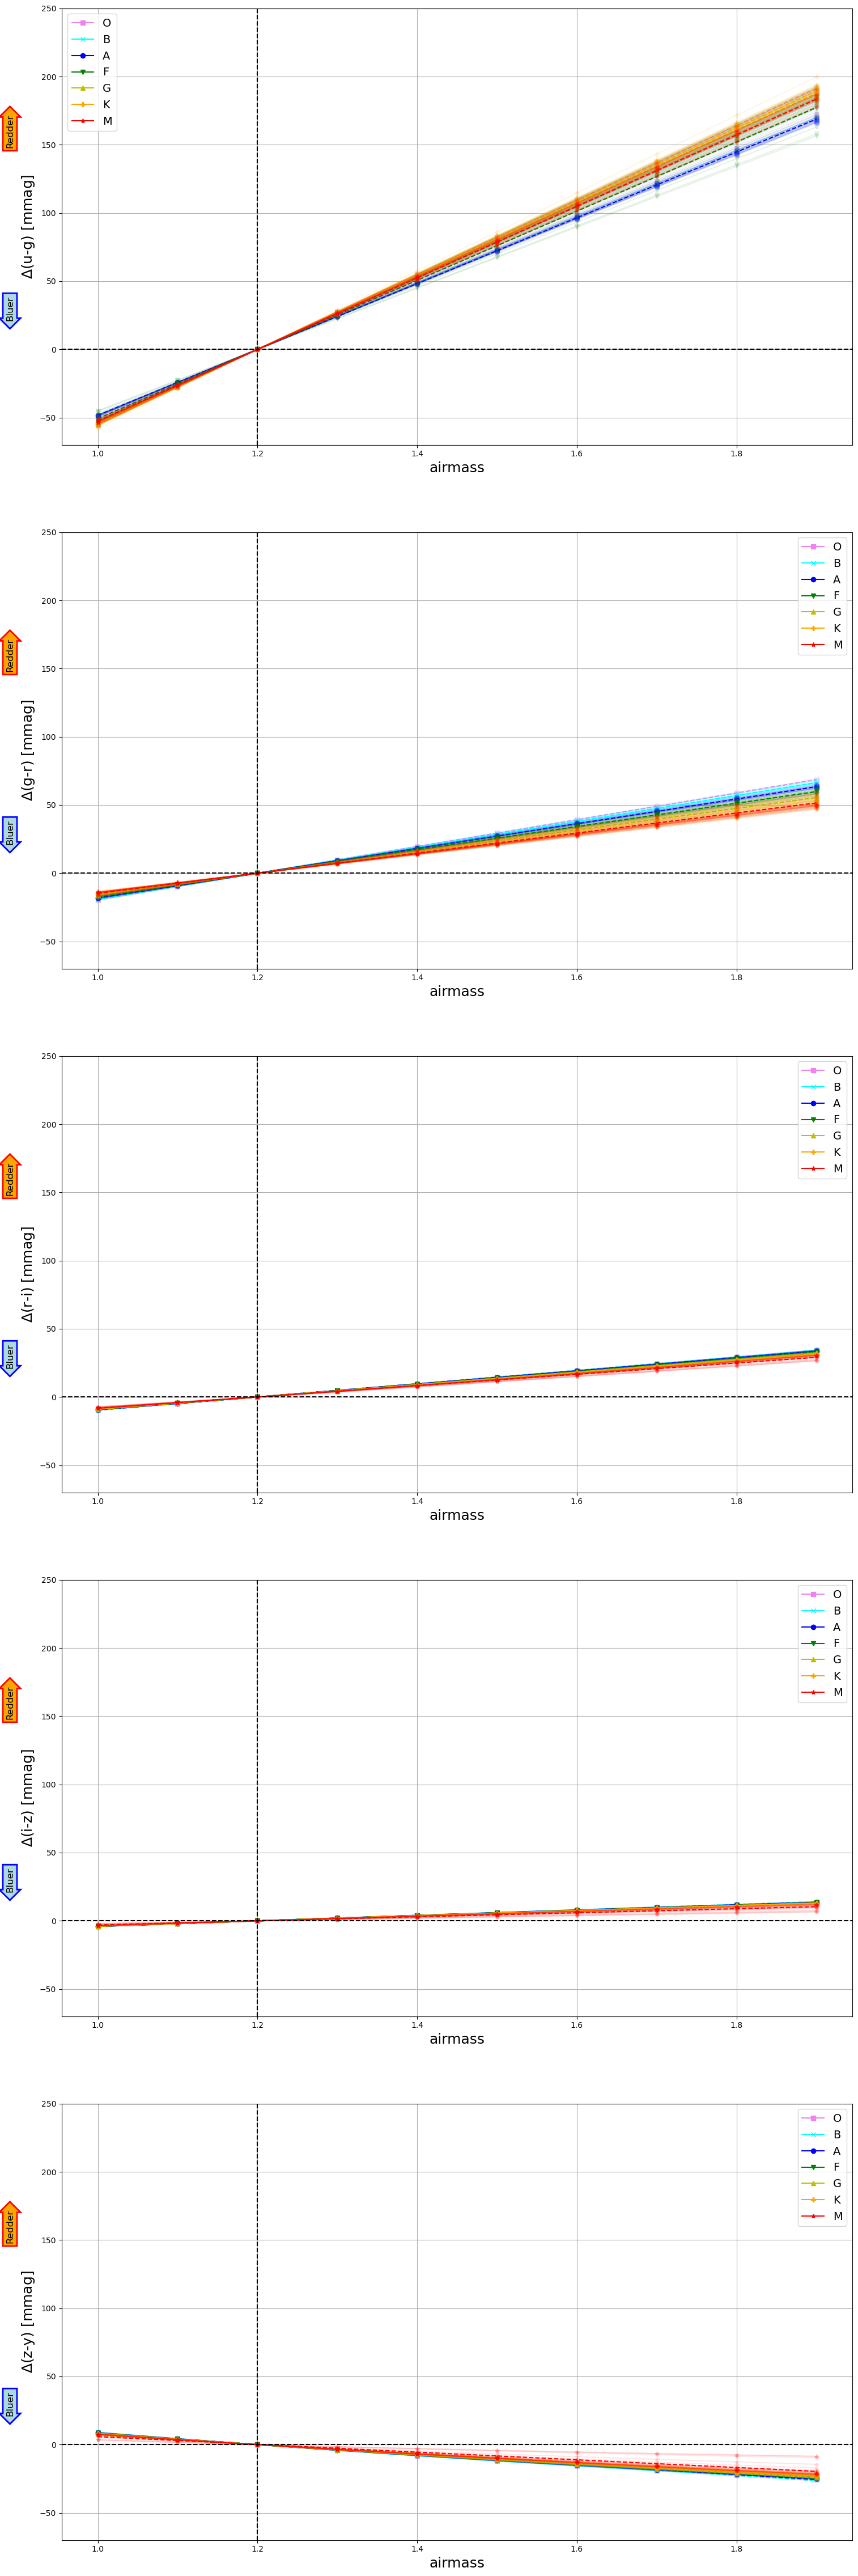

In [24]:
plt.ioff()
fig_rows = len(colors)
fig_cols = 1
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(18,58))

yrange = (-70.,250.)

am_model_dict = {}
for row,color in enumerate(colors):
    for spec_type in spectral_types:
        param_list = []
        for si in am_color_dict[spec_type]:
            delta_c_ = (am_color_dict[spec_type][si][color]-am_color_ref_dict[spec_type][si][color])*1000.
            
            p_,cov_ = curve_fit(lin_fun,am_vals,delta_c_/1000.)
            param_list.append(p_)
            
            axs[row].plot(am_vals,delta_c_,marker=type_markers[spec_type],c=type_colors[spec_type],alpha=0.1)
            
        param_list = np.array(param_list)
        mean_params_ = np.mean(param_list,axis=0)
        am_model_dict[(spec_type,color)] = mean_params_
        
        model_ = lin_fun(am_vals,mean_params_[0],mean_params_[1])*1000.
        axs[row].plot(am_vals,model_,ls='--',marker='',c=type_colors[spec_type])
        axs[row].plot([],[],marker=type_markers[spec_type],c=type_colors[spec_type],label=spec_type)
    axs[row].axhline(y=0.0,ls='--',color='k')
    axs[row].axvline(x=am0,ls='--',color='k')
    axs[row].set_ylim(yrange)
    axs[row].grid()
    axs[row].set_xlabel('airmass',fontsize=18)
    axs[row].set_ylabel(r'$\Delta$'+'('+color+') [mmag]',fontsize=18)
    axs[row].text(0.89,30.,"Bluer",ha="center",va="center",rotation=90.,size=12,
                  bbox=dict(boxstyle="larrow,pad=0.3",fc="lightblue",ec="blue",lw=2))
    axs[row].text(0.89,160.,"Redder",ha="center",va="center",rotation=90.,size=12,
                  bbox=dict(boxstyle="rarrow,pad=0.3",fc="orange",ec="red",lw=2))
    axs[row].legend(loc="best",fontsize=14)
            
    
display(fig)

del fig,axs
plt.ion() 

# 3D visualization 

For PWV we focus on the reddest colors 

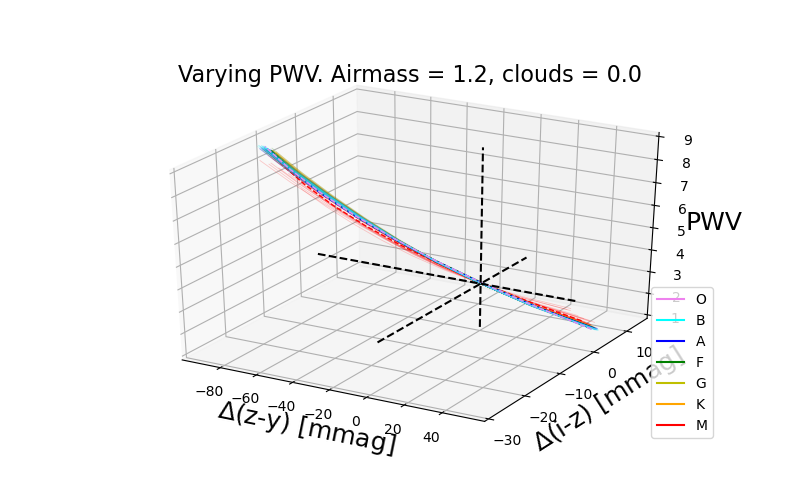

In [25]:

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='3d')

cy = 'i-z'
cx = 'z-y'
        
iso_vals1 = []
iso_vals2 = []
for spec_type in spectral_types[::-1]:
    for si in pwv_color_dict[spec_type]:
        delta1 = (pwv_color_dict[spec_type][si][cx.lower()]-pwv_color_ref_dict[spec_type][si][cx.lower()])*1000.
        delta2 = (pwv_color_dict[spec_type][si][cy.lower()]-pwv_color_ref_dict[spec_type][si][cy.lower()])*1000.
        msize = [10.]
        msize = msize+[40.]*(len(delta1)-2)
        msize.append(110.)
        
        iso_vals1.append(delta1)
        iso_vals2.append(delta2)
        
        #ax.scatter(delta1,delta2,pwv_vals,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
        ax.plot(delta1,delta2,pwv_vals,ls='-',linewidth=0.6,marker='',color=type_colors[spec_type],alpha=0.2,zorder=-1)
    params1 = pwv_model_dict[(spec_type,cx.lower())]
    params2 = pwv_model_dict[(spec_type,cy.lower())]
    model1 = quad_fun(pwv_vals,params1[0],params1[1],params1[2])*1000.
    model2 = quad_fun(pwv_vals,params2[0],params2[1],params2[2])*1000.
    ax.plot(model1,model2,pwv_vals,ls='--',linewidth=1.0,marker='',color=type_colors[spec_type],alpha=1.0,zorder=-1)
    
for spec_type in spectral_types:
    ax.plot([],[],[],c=type_colors[spec_type],ls='-',marker='',label=spec_type)
            
'''
        for sn in sn_colour_dict.keys():
                delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
                delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1_sn)
                iso_vals2.append(delta2_sn)
                
                axs.scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
                axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        axs.plot([],[],c='k',ls='',marker='o',label='SNe Ia')    
        
        delta1_flat = (flat_colour_dict[cx.lower()]-flat_colour_dict_ref[cx.lower()])*1000.
        delta2_flat = (flat_colour_dict[cy.lower()]-flat_colour_dict_ref[cy.lower()])*1000.
        axs.scatter(delta1_flat,delta2_flat,c='k',marker='s',s=msize)
        axs.plot(delta1_flat,delta2_flat,ls='-',linewidth=2.0,marker='',color='k',alpha=1.0,zorder=1)
        axs.plot([],[],c='k',ls='-',marker='s',label='AB spec')


iso_vals1 = np.array(iso_vals1)
iso_vals2 = np.array(iso_vals2)
for val in range(iso_vals1.shape[1]):
    #print(iso_vals1[:,val])
    sort_index = np.argsort(iso_vals1[:,val])
    ax.plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
'''    

xrange = np.linspace(np.min(iso_vals1),np.max(iso_vals1),100)
yrange = np.linspace(np.min(iso_vals2),np.max(iso_vals2),100)
zrange = np.linspace(np.min(pwv_vals),np.max(pwv_vals),100)

ax.plot(xrange,np.zeros(len(yrange)),np.ones(len(zrange))*pwv0,'k--')
ax.plot(np.zeros(len(xrange)),yrange,np.ones(len(zrange))*pwv0,'k--')
ax.plot(np.zeros(len(xrange)),np.zeros(len(yrange)),zrange,'k--')

ax.grid()
#ax.set_xticks(fontsize=20)
#ax.set_yticks(fontsize=20)
#ax.set_xlim(-100.,60.)#################
#ax.set_ylim(-35.,15.)#################
        
ax.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
ax.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
ax.set_zlabel('PWV',fontsize=18)
ax.set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format('PWV',am0,cloud0),fontsize=16)
ax.legend(loc='lower right',fontsize=10)


For aerosols we focus on the bluest colors 

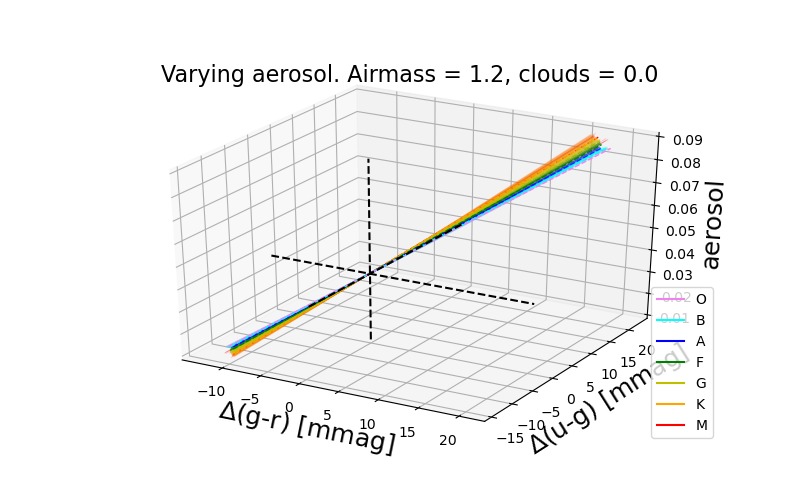

In [26]:

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='3d')

cy = 'u-g'
cx = 'g-r'
        
iso_vals1 = []
iso_vals2 = []
for spec_type in spectral_types[::-1]:
    for si in aero_color_dict[spec_type]:
        delta1 = (aero_color_dict[spec_type][si][cx.lower()]-aero_color_ref_dict[spec_type][si][cx.lower()])*1000.
        delta2 = (aero_color_dict[spec_type][si][cy.lower()]-aero_color_ref_dict[spec_type][si][cy.lower()])*1000.
        msize = [10.]
        msize = msize+[40.]*(len(delta1)-2)
        msize.append(110.)
        
        iso_vals1.append(delta1)
        iso_vals2.append(delta2)
        
        #ax.scatter(delta1,delta2,pwv_vals,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
        ax.plot(delta1,delta2,aero_vals,ls='-',linewidth=0.6,marker='',color=type_colors[spec_type],alpha=0.2,zorder=-1)
    params1 = aero_model_dict[(spec_type,cx.lower())]
    params2 = aero_model_dict[(spec_type,cy.lower())]
    model1 = lin_fun(aero_vals,params1[0],params1[1])*1000.
    model2 = lin_fun(aero_vals,params2[0],params2[1])*1000.
    ax.plot(model1,model2,aero_vals,ls='--',linewidth=1.0,marker='',color=type_colors[spec_type],alpha=1.0,zorder=-1)
        
for spec_type in spectral_types:
    ax.plot([],[],[],c=type_colors[spec_type],ls='-',marker='',label=spec_type)
            
'''
        for sn in sn_colour_dict.keys():
                delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
                delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1_sn)
                iso_vals2.append(delta2_sn)
                
                axs.scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
                axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        axs.plot([],[],c='k',ls='',marker='o',label='SNe Ia')    
        
        delta1_flat = (flat_colour_dict[cx.lower()]-flat_colour_dict_ref[cx.lower()])*1000.
        delta2_flat = (flat_colour_dict[cy.lower()]-flat_colour_dict_ref[cy.lower()])*1000.
        axs.scatter(delta1_flat,delta2_flat,c='k',marker='s',s=msize)
        axs.plot(delta1_flat,delta2_flat,ls='-',linewidth=2.0,marker='',color='k',alpha=1.0,zorder=1)
        axs.plot([],[],c='k',ls='-',marker='s',label='AB spec')


iso_vals1 = np.array(iso_vals1)
iso_vals2 = np.array(iso_vals2)
for val in range(iso_vals1.shape[1]):
    #print(iso_vals1[:,val])
    sort_index = np.argsort(iso_vals1[:,val])
    ax.plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
'''    

xrange = np.linspace(np.min(iso_vals1),np.max(iso_vals1),100)
yrange = np.linspace(np.min(iso_vals2),np.max(iso_vals2),100)
zrange = np.linspace(np.min(aero_vals),np.max(aero_vals),100)

ax.plot(xrange,np.zeros(len(yrange)),np.ones(len(zrange))*aero0,'k--')
ax.plot(np.zeros(len(xrange)),yrange,np.ones(len(zrange))*aero0,'k--')
ax.plot(np.zeros(len(xrange)),np.zeros(len(yrange)),zrange,'k--')

ax.grid()
#ax.set_xticks(fontsize=20)
#ax.set_yticks(fontsize=20)
#ax.set_xlim(-100.,60.)#################
#ax.set_ylim(-35.,15.)#################
        
ax.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
ax.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
ax.set_zlabel('aerosol',fontsize=18)
ax.set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format('aerosol',am0,cloud0),fontsize=16)
ax.legend(loc='lower right',fontsize=10)


Airmass has its most important impact at the bluest colors, but it has a wide impact 

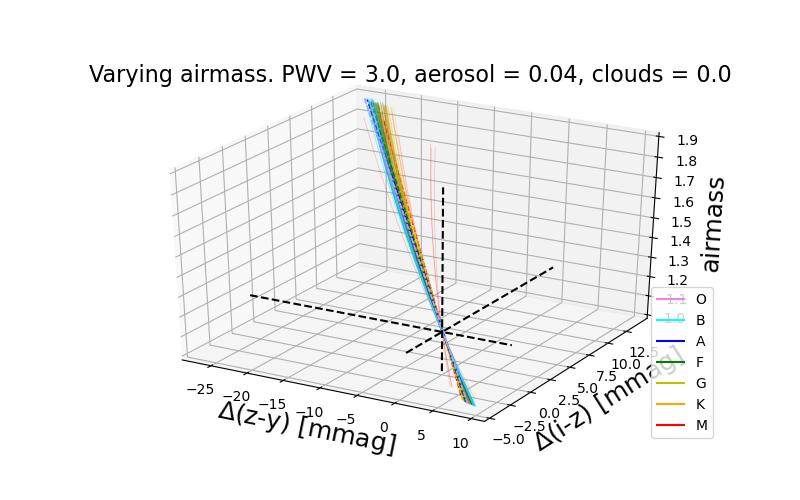

In [27]:

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='3d')

cy = 'i-z'
cx = 'z-y'
        
iso_vals1 = []
iso_vals2 = []
for spec_type in spectral_types[::-1]:
    for si in am_color_dict[spec_type]:
        delta1 = (am_color_dict[spec_type][si][cx.lower()]-am_color_ref_dict[spec_type][si][cx.lower()])*1000.
        delta2 = (am_color_dict[spec_type][si][cy.lower()]-am_color_ref_dict[spec_type][si][cy.lower()])*1000.
        msize = [10.]
        msize = msize+[40.]*(len(delta1)-2)
        msize.append(110.)
        
        iso_vals1.append(delta1)
        iso_vals2.append(delta2)
        
        #ax.scatter(delta1,delta2,pwv_vals,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
        ax.plot(delta1,delta2,am_vals,ls='-',linewidth=0.6,marker='',color=type_colors[spec_type],alpha=0.2,zorder=-1)
    params1 = am_model_dict[(spec_type,cx.lower())]
    params2 = am_model_dict[(spec_type,cy.lower())]
    model1 = lin_fun(am_vals,params1[0],params1[1])*1000.
    model2 = lin_fun(am_vals,params2[0],params2[1])*1000.
    ax.plot(model1,model2,am_vals,ls='--',linewidth=1.0,marker='',color=type_colors[spec_type],alpha=1.0,zorder=-1)
    
for spec_type in spectral_types:
    ax.plot([],[],[],c=type_colors[spec_type],ls='-',marker='',label=spec_type)
            
'''
        for sn in sn_colour_dict.keys():
                delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
                delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
                
                iso_vals1.append(delta1_sn)
                iso_vals2.append(delta2_sn)
                
                axs.scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
                axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
        axs.plot([],[],c='k',ls='',marker='o',label='SNe Ia')    
        
        delta1_flat = (flat_colour_dict[cx.lower()]-flat_colour_dict_ref[cx.lower()])*1000.
        delta2_flat = (flat_colour_dict[cy.lower()]-flat_colour_dict_ref[cy.lower()])*1000.
        axs.scatter(delta1_flat,delta2_flat,c='k',marker='s',s=msize)
        axs.plot(delta1_flat,delta2_flat,ls='-',linewidth=2.0,marker='',color='k',alpha=1.0,zorder=1)
        axs.plot([],[],c='k',ls='-',marker='s',label='AB spec')


iso_vals1 = np.array(iso_vals1)
iso_vals2 = np.array(iso_vals2)
for val in range(iso_vals1.shape[1]):
    #print(iso_vals1[:,val])
    sort_index = np.argsort(iso_vals1[:,val])
    ax.plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)
'''    

xrange = np.linspace(np.min(iso_vals1),np.max(iso_vals1),100)
yrange = np.linspace(np.min(iso_vals2),np.max(iso_vals2),100)
zrange = np.linspace(np.min(am_vals),np.max(am_vals),100)

ax.plot(xrange,np.zeros(len(yrange)),np.ones(len(zrange))*am0,'k--')
ax.plot(np.zeros(len(xrange)),yrange,np.ones(len(zrange))*am0,'k--')
ax.plot(np.zeros(len(xrange)),np.zeros(len(yrange)),zrange,'k--')

ax.grid()
#ax.set_xticks(fontsize=20)
#ax.set_yticks(fontsize=20)
#ax.set_xlim(-100.,60.)#################
#ax.set_ylim(-35.,15.)#################
        
ax.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
ax.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
ax.set_zlabel('airmass',fontsize=18)
ax.set_title('Varying {0}. PWV = {1}, aerosol = {2}, clouds = {3}'.format('airmass',pwv0,aero0,cloud0),fontsize=16)
ax.legend(loc='lower right',fontsize=10)


# Evaluate model and calculate correction 

The quantity we are working with is $\Delta \vec{c} = \vec{c}_{obs} - \vec{c}_{std}$, with $\vec{c}_{std}$ the colors observed in a standard atmosphere. Then, for each component of the color vector we have that the variation with an atmospheric parameter, $p$, is given by 

$$\frac{\partial c^{xy}}{\partial p} = \frac{\Delta c^{xy}}{\Delta p} = v^{xy} \, .$$ 

Each component of the vector $\vec{v}$ corresponds to the derivative with respect to $p$ of the fitted functions, $f^{\prime \, xy}(p)$. 

Let's have a look at the trajectory in the $\Delta c$ - PWV plane of an M-type star 

In [28]:
test_types = ['O']
test_specs = [0]

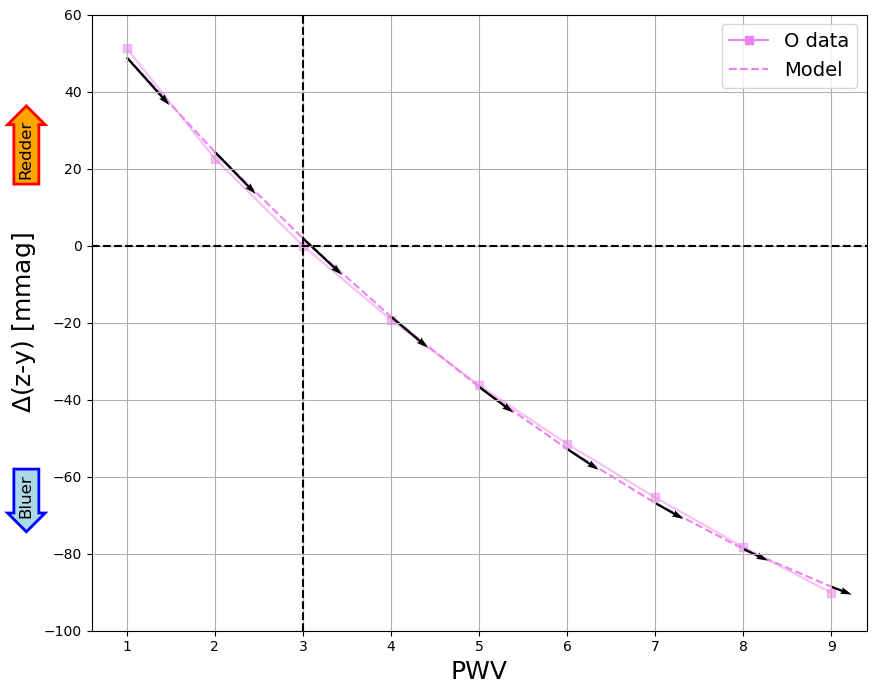

In [29]:
test_color = ['z-y']

plt.ioff()
fig_rows = 1
fig_cols = 1
fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(10,8))

yrange = (-100.,60.)

for row,color in enumerate(test_color):
    for spec_type in test_types:
        param_list = []
        for si in test_specs:
            delta_c_ = (pwv_color_dict[spec_type][si][color]-pwv_color_ref_dict[spec_type][si][color])*1000.
            
            p_,cov_ = curve_fit(quad_fun,pwv_vals,delta_c_/1000.)
            param_list.append(p_)
            
            axs.plot(pwv_vals,delta_c_,marker=type_markers[spec_type],c=type_colors[spec_type],alpha=0.5,zorder=-1)
            
        axs.plot([],[],marker=type_markers[spec_type],c=type_colors[spec_type],label=spec_type+' data')
        
        param_list = np.array(param_list)
        mean_params_ = np.mean(param_list,axis=0)
        
        model_ = quad_fun(pwv_vals,mean_params_[0],mean_params_[1],mean_params_[2])*1000.
        axs.plot(pwv_vals,model_,ls='--',marker='',c=type_colors[spec_type],label='Model',zorder=-1)
        
        dev_ = quad_dev(pwv_vals,mean_params_[0],mean_params_[1])*1000.
    
        #axs.quiver(pwv_vals,delta_c_,np.ones(len(pwv_vals)),dev_,color='k',angles='xy',width=0.003)
        axs.quiver(pwv_vals,model_,np.ones(len(pwv_vals)),dev_,color='k',angles='xy',width=0.003,zorder=1)
        
    axs.axhline(y=0.0,ls='--',color='k')
    axs.axvline(x=pwv0,ls='--',color='k')
    axs.set_ylim(yrange)
    axs.grid()
    axs.text(-0.14,-65.,"Bluer",ha="center",va="center",rotation=90.,size=12,
                  bbox=dict(boxstyle="larrow,pad=0.3",fc="lightblue",ec="blue",lw=2))
    axs.text(-0.14,25.,"Redder",ha="center",va="center",rotation=90.,size=12,
                  bbox=dict(boxstyle="rarrow,pad=0.3",fc="orange",ec="red",lw=2))
    axs.set_xlabel('PWV',fontsize=18)
    axs.set_ylabel(r'$\Delta$'+'('+color+') [mmag]',fontsize=18)
    axs.legend(loc="best",fontsize=14)
            
    
display(fig)

del fig,axs
plt.ion() 

3D view of the trajectories 

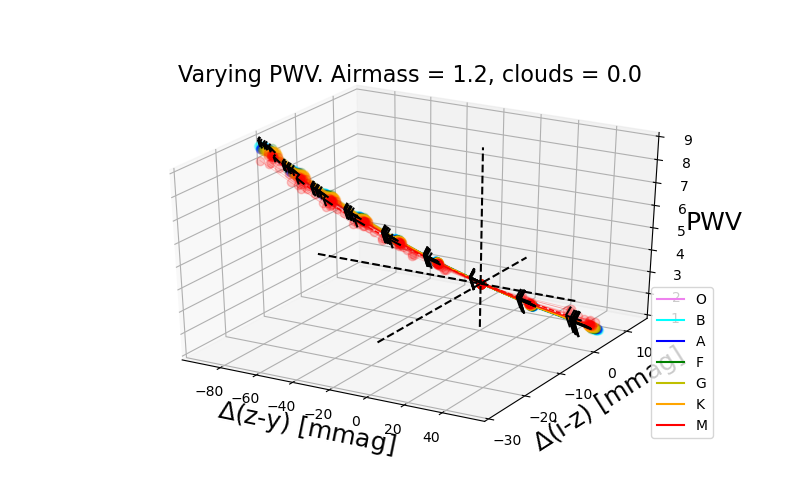

In [30]:

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='3d')

cy = 'i-z'
cx = 'z-y'
        
iso_vals1 = []
iso_vals2 = []
for spec_type in spectral_types:
    for si in pwv_color_dict[spec_type]:
        delta1 = (pwv_color_dict[spec_type][si][cx.lower()]-pwv_color_ref_dict[spec_type][si][cx.lower()])*1000.
        delta2 = (pwv_color_dict[spec_type][si][cy.lower()]-pwv_color_ref_dict[spec_type][si][cy.lower()])*1000.
        msize = [10.]
        msize = msize+[40.]*(len(delta1)-2)
        msize.append(110.)
        
        iso_vals1.append(delta1)
        iso_vals2.append(delta2)
        
        #ax.scatter(delta1,delta2,pwv_vals,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
        ax.plot(delta1,delta2,pwv_vals,ls='-',linewidth=0.6,marker='o',color=type_colors[spec_type],alpha=0.2,zorder=-1)
    params1 = pwv_model_dict[(spec_type,cx.lower())]
    params2 = pwv_model_dict[(spec_type,cy.lower())]
    model1 = quad_fun(pwv_vals,params1[0],params1[1],params1[2])*1000.
    model2 = quad_fun(pwv_vals,params2[0],params2[1],params2[2])*1000.
    ax.plot(model1,model2,pwv_vals,ls='--',linewidth=1.0,marker='',color=type_colors[spec_type],alpha=1.0,zorder=-1)
    
    dev1 = quad_dev(pwv_vals,params1[0],params1[1])*1000.
    dev2 = quad_dev(pwv_vals,params2[0],params2[1])*1000.
    
    
    #ax.quiver(delta1,delta2,pwv_vals,dev1,dev2,np.ones(len(delta1)),color='k',length=0.3,normalize=False)
    ax.quiver(model1,model2,pwv_vals,dev1,dev2,np.ones(len(delta1)),color='k',length=0.3,normalize=False)
    
for spec_type in spectral_types:
    ax.plot([],[],[],c=type_colors[spec_type],ls='-',marker='',label=spec_type)
    

xrange = np.linspace(np.min(iso_vals1),np.max(iso_vals1),100)
yrange = np.linspace(np.min(iso_vals2),np.max(iso_vals2),100)
zrange = np.linspace(np.min(pwv_vals),np.max(pwv_vals),100)

ax.plot(xrange,np.zeros(len(yrange)),np.ones(len(zrange))*pwv0,'k--')
ax.plot(np.zeros(len(xrange)),yrange,np.ones(len(zrange))*pwv0,'k--')
ax.plot(np.zeros(len(xrange)),np.zeros(len(yrange)),zrange,'k--')

ax.grid()
#ax.set_xticks(fontsize=20)
#ax.set_yticks(fontsize=20)
#ax.set_xlim(-100.,60.)#################
#ax.set_ylim(-35.,15.)#################
        
ax.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
ax.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
ax.set_zlabel('PWV',fontsize=18)
ax.set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format('PWV',am0,cloud0),fontsize=16)
ax.legend(loc='lower right',fontsize=10)


Now we compute the corrections for each color, $c^{xy}$: 
$$c^{xy}_{corr} = c^{xy}_{obs} - \int_{p_{std}}^{p_{obs}} f^{\prime \, xy}(p) dp \, ,$$ 
where 
$$f^{\prime \, xy}(p) = \frac{\partial c^{xy}}{\partial p} = \frac{\partial \Delta c^{xy}}{\partial p} \, . $$ 
Then, the color corrections are given by the primitive of $f^{\prime \, xy}$, which are just the $f^{xy}(p)$ functions that we fitted above for each color change. 

In [31]:
pwv_corr_dict = {}
for color in colors:
    for spec_type in spectral_types:
        
        params_ = pwv_model_dict[(spec_type,color.lower())]
        def df_(x):
            return quad_dev(x,params_[0],params_[1])
        
        correction = []
        for p in pwv_vals:
            correction_ = quad(df_,pwv0,p)[0]
            correction.append(correction_)
        correction = np.array(correction)
        #correction2 = np.trapz(df_(pwv_vals),pwv_vals)
        pwv_corr_dict[(spec_type,color)] = correction
        
    

# Evaluate the color corrections 

Let's focus on the PWV corrections: 

In [32]:
pwv_colors = ['r-i','i-z','z-Y']

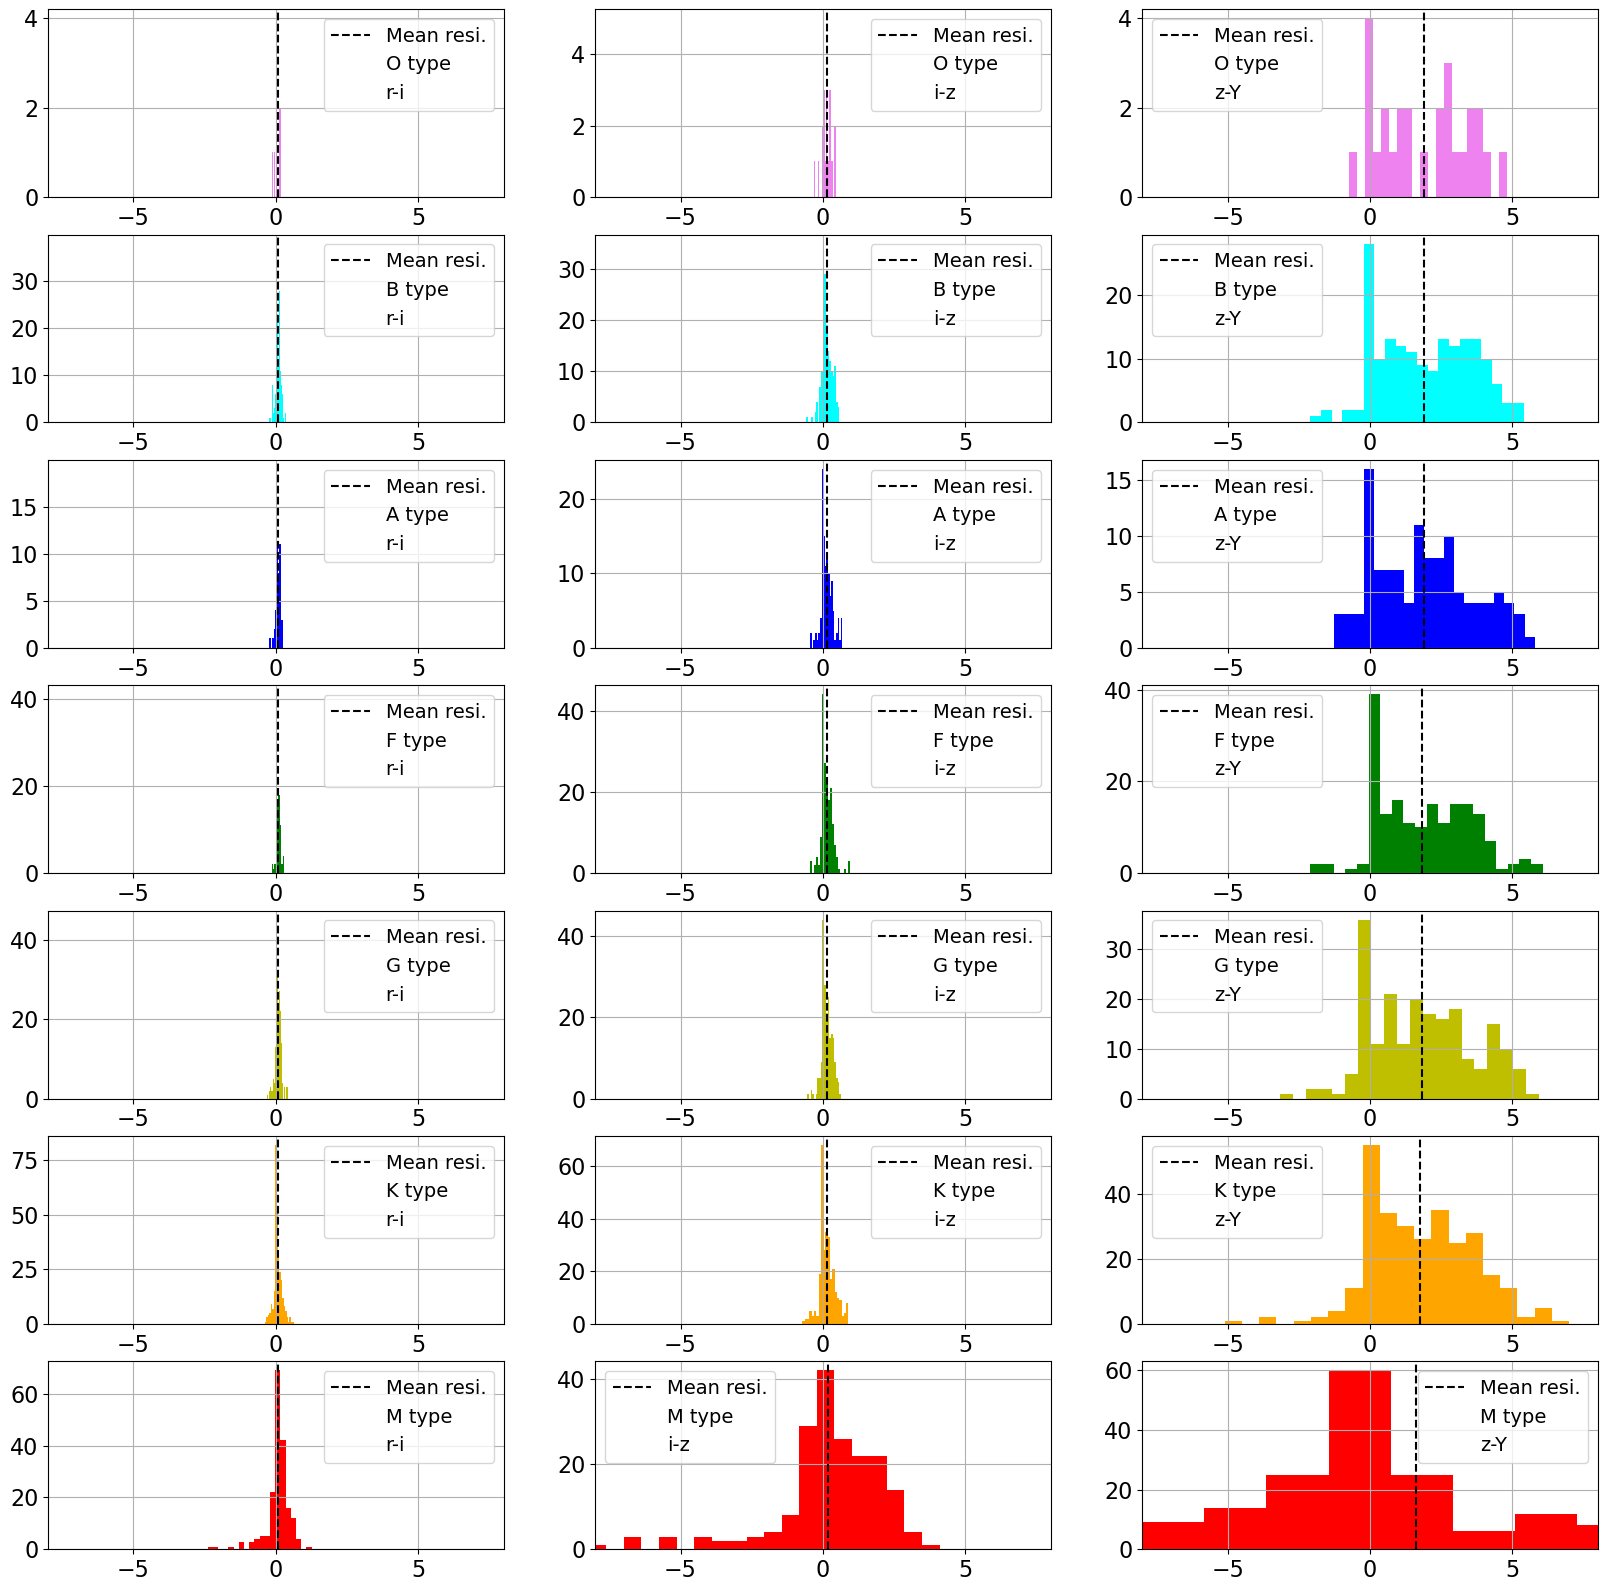

In [33]:
plt.ioff()

fig_rows = len(spectral_types)
fig_cols = len(pwv_colors)

rangex2 = (-250.,-70.)
rangey2 = (-130.,-100.)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=(20,20))

for row in range(fig_rows):
    st_ = spectral_types[row]
    
    for col in range(fig_cols):
        c_ = pwv_colors[col]
        corr_ = pwv_corr_dict[(st_,c_.lower())]*1000.
        
        residual_ = []
        for si in pwv_color_dict[st_]:
            c_obs_ = np.array(pwv_color_dict[st_][si][c_.lower()]*1000.)
            
            c_ref_ = pwv_color_ref_dict[st_][si][c_.lower()]*1000.
                
            c_corr_ = np.array(c_obs_-corr_)
            resi_ = c_corr_-c_ref_
            
            residual_.append(resi_)
            
        residual_ = np.array(residual_).flatten()
        mean_residual_ = np.mean(residual_)
        
        axs[row,col].hist(residual_,bins=20,color=type_colors[st_])
        axs[row,col].axvline(x=mean_residual_,ls='--',c='k',label='Mean resi.')
        axs[row,col].plot([],[],ls='',marker='',label='{0} type'.format(st_))
        axs[row,col].plot([],[],ls='',marker='',label='{0}'.format(c_))
        axs[row,col].grid()
        axs[row,col].tick_params(axis='x', labelsize=16)
        axs[row,col].tick_params(axis='y', labelsize=16)
        axs[row,col].set_xlim(-8.,8.)
        axs[row,col].legend(loc="best",fontsize=14)

        
display(fig)

del fig,axs
plt.ion() 

In [34]:
test_type = 'M'
test_spec = 0

In [35]:
pwv1 = np.min(pwv_vals)
pwv2 = np.max(pwv_vals)
index1 = np.where(pwv_vals==pwv1)[0][0]
index2 = np.where(pwv_vals==pwv2)[0][0]
indices = np.array([index1,index2])

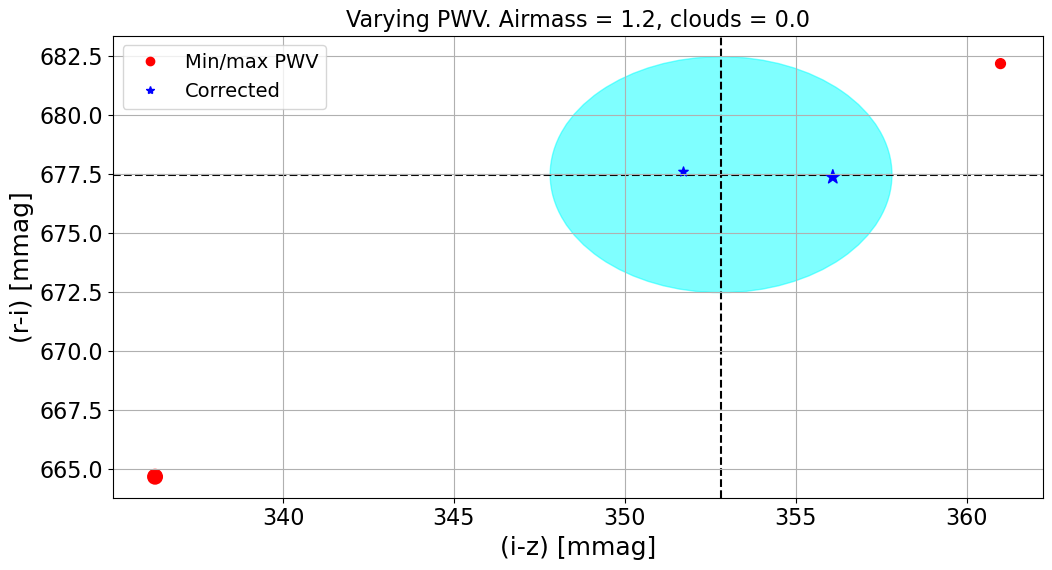

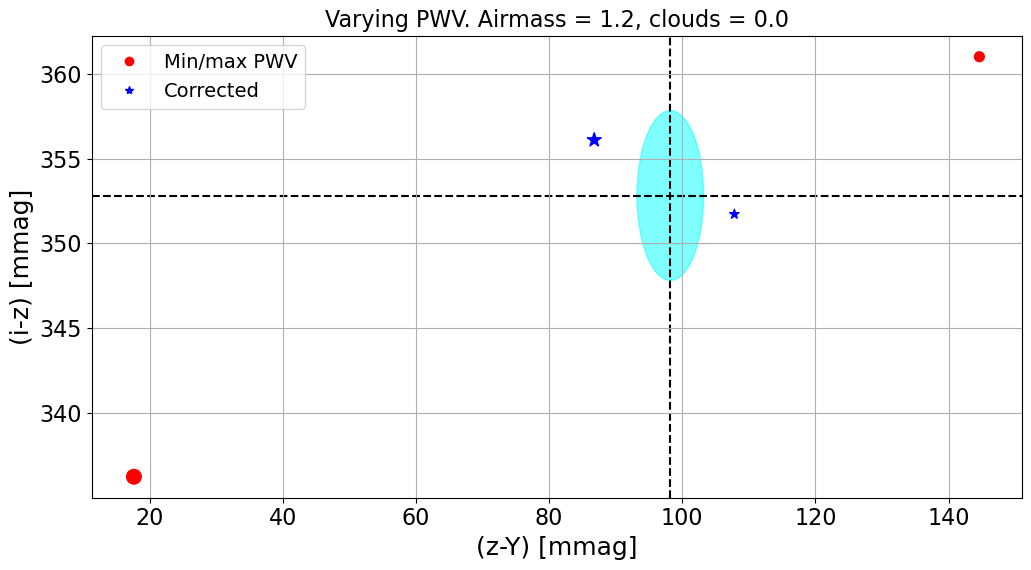

In [36]:
plt.ioff()

fig_rows = len(pwv_colors)-1

rangex2 = (-250.,-70.)
rangey2 = (-130.,-100.)

i = 0
for row in range(fig_rows):
    if i<len(filters)-2:
        fig, axs = plt.subplots(1, 1, figsize=(12,6))
        cy = pwv_colors[i]
        cx = pwv_colors[i+1]
        
        corr1 = pwv_corr_dict[(test_type,cx.lower())][indices]*1000.
        corr2 = pwv_corr_dict[(test_type,cy.lower())][indices]*1000.
            
        c1_obs = pwv_color_dict[test_type][test_spec][cx.lower()][indices]*1000.
        c2_obs = pwv_color_dict[test_type][test_spec][cy.lower()][indices]*1000.
        
        c1_ref = pwv_color_ref_dict[test_type][test_spec][cx.lower()]*1000.
        c2_ref = pwv_color_ref_dict[test_type][test_spec][cy.lower()]*1000.
        
        c1_corr = c1_obs-corr1
        c2_corr = c2_obs-corr2
        
        msize = [50.,110.]
        
        axs.scatter(c1_obs,c2_obs,c='r',marker='o',s=msize,alpha=1.0,zorder=1)
        axs.scatter(c1_corr,c2_corr,c='b',marker='*',s=msize,alpha=1.0,zorder=1)
        axs.axvline(x=c1_ref,ls='--',color='k',zorder=-1)
        axs.axhline(y=c2_ref,ls='--',color='k',zorder=-1)
        circle = plt.Circle((c1_ref, c2_ref), 5., color='cyan', fill=True, alpha=0.5, zorder=-1)
        axs.add_patch(circle)
                
        axs.plot([],[],c='r',ls='',marker='o',label='Min/max PWV')
        axs.plot([],[],c='b',ls='',marker='*',label='Corrected')
            
        axs.grid()
        axs.tick_params(axis='x', labelsize=16)
        axs.tick_params(axis='y', labelsize=16)
        #axs.set_xlim(rangex2)
        #axs.set_ylim(rangey2)
        #axs.set_aspect('equal')
        
        axs.set_xlabel('('+cx+') [mmag]',fontsize=18)
        axs.set_ylabel('('+cy+') [mmag]',fontsize=18)
        axs.set_title('Varying {0}. Airmass = {1}, clouds = {2}'.format('PWV',am0,cloud0),fontsize=16)
        axs.legend(loc="upper left",fontsize=14)
        i += 1
        
    display(fig)

del fig,axs
plt.ion() 

# Now we make a color-color diagram of all stellar types together 

First, let's have a look at the trajectory of the colors (not $\Delta c$) as a function of the atmospheric parameters 

PWV 

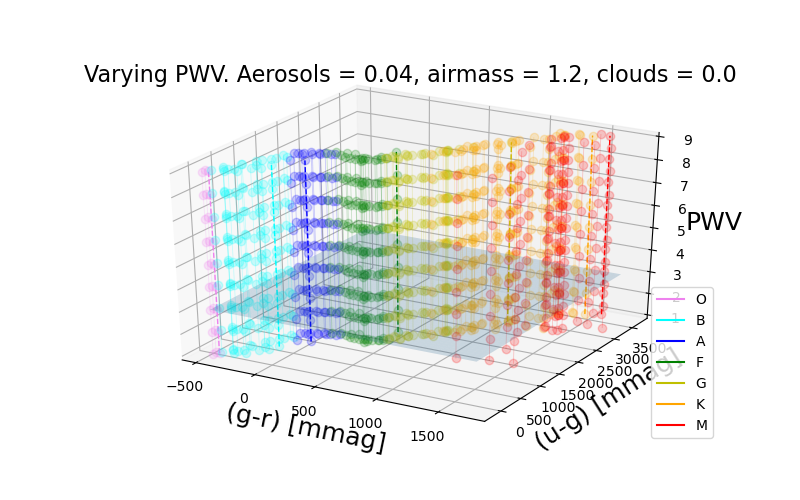

In [37]:

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='3d')

cy = 'u-g'
cx = 'g-r'

minc1 = []
maxc1 = []
minc2 = []
maxc2 = []
for spec_type in spectral_types:
    for si in pwv_color_dict[spec_type]:
        c1 = pwv_color_dict[spec_type][si][cx.lower()]*1000.
        c2 = pwv_color_dict[spec_type][si][cy.lower()]*1000.
        
        c1_ref = pwv_color_ref_dict[spec_type][si][cx.lower()]*1000.
        c2_ref = pwv_color_ref_dict[spec_type][si][cy.lower()]*1000.
        
        minc1.append(np.min(c1))
        maxc1.append(np.max(c1))
        minc2.append(np.min(c2))
        maxc2.append(np.max(c2))
        
        ax.plot(c1,c2,pwv_vals,ls='-',linewidth=0.6,marker='o',color=type_colors[spec_type],alpha=0.2,zorder=-1)
    params1 = pwv_model_dict[(spec_type,cx.lower())]
    params2 = pwv_model_dict[(spec_type,cy.lower())]
    model1 = quad_fun(pwv_vals,params1[0],params1[1],params1[2])*1000.
    model2 = quad_fun(pwv_vals,params2[0],params2[1],params2[2])*1000.
    ax.plot(model1+c1_ref,model2+c2_ref,pwv_vals,ls='--',linewidth=1.0,marker='',color=type_colors[spec_type],alpha=1.0,zorder=-1)
    
    
for spec_type in spectral_types:
    ax.plot([],[],[],c=type_colors[spec_type],ls='-',marker='',label=spec_type)
    

X, Y = np.meshgrid(np.linspace(np.min(minc1),np.max(maxc1),100), np.linspace(np.min(minc2),np.max(maxc2),100))
Z = np.ones(X.shape)*pwv0
ax.plot_surface(X, Y, Z, alpha=0.2)

ax.grid()  
ax.set_xlabel('('+cx+') [mmag]',fontsize=18)
ax.set_ylabel('('+cy+') [mmag]',fontsize=18)
ax.set_zlabel('PWV',fontsize=18)
ax.set_title('Varying {0}. Aerosols = {1}, airmass = {2}, clouds = {3}'.format('PWV',aero0,am0,cloud0),fontsize=16)
ax.legend(loc='lower right',fontsize=10)


Aerosols 

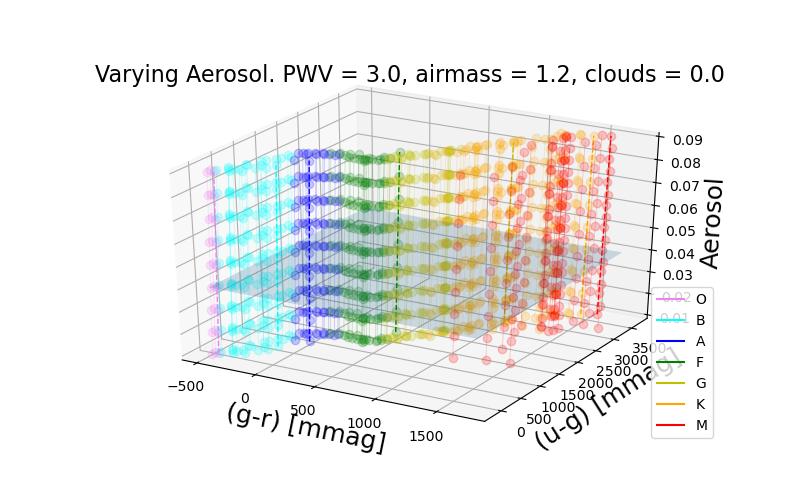

In [38]:

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='3d')

cy = 'u-g'
cx = 'g-r'

minc1 = []
maxc1 = []
minc2 = []
maxc2 = []
for spec_type in spectral_types:
    for si in pwv_color_dict[spec_type]:
        c1 = aero_color_dict[spec_type][si][cx.lower()]*1000.
        c2 = aero_color_dict[spec_type][si][cy.lower()]*1000.
        
        c1_ref = aero_color_ref_dict[spec_type][si][cx.lower()]*1000.
        c2_ref = aero_color_ref_dict[spec_type][si][cy.lower()]*1000.
        
        minc1.append(np.min(c1))
        maxc1.append(np.max(c1))
        minc2.append(np.min(c2))
        maxc2.append(np.max(c2))
        
        #ax.scatter(c1,c2,pwv_vals,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
        ax.plot(c1,c2,aero_vals,ls='-',linewidth=0.6,marker='o',color=type_colors[spec_type],alpha=0.2,zorder=-1)
    params1 = aero_model_dict[(spec_type,cx.lower())]
    params2 = aero_model_dict[(spec_type,cy.lower())]
    model1 = lin_fun(aero_vals,params1[0],params1[1])*1000.
    model2 = lin_fun(aero_vals,params2[0],params2[1])*1000.
    ax.plot(model1+c1_ref,model2+c2_ref,aero_vals,ls='--',linewidth=1.0,marker='',color=type_colors[spec_type],alpha=1.0,zorder=-1)
    
    
for spec_type in spectral_types:
    ax.plot([],[],[],c=type_colors[spec_type],ls='-',marker='',label=spec_type)
    

X, Y = np.meshgrid(np.linspace(np.min(minc1),np.max(maxc1),100), np.linspace(np.min(minc2),np.max(maxc2),100))
Z = np.ones(X.shape)*aero0
ax.plot_surface(X, Y, Z, alpha=0.2)

ax.grid()
ax.set_xlabel('('+cx+') [mmag]',fontsize=18)
ax.set_ylabel('('+cy+') [mmag]',fontsize=18)
ax.set_zlabel('Aerosol',fontsize=18)
ax.set_title('Varying {0}. PWV = {1}, airmass = {2}, clouds = {3}'.format('Aerosol',pwv0,am0,cloud0),fontsize=16)
ax.legend(loc='lower right',fontsize=10)


Airmass 

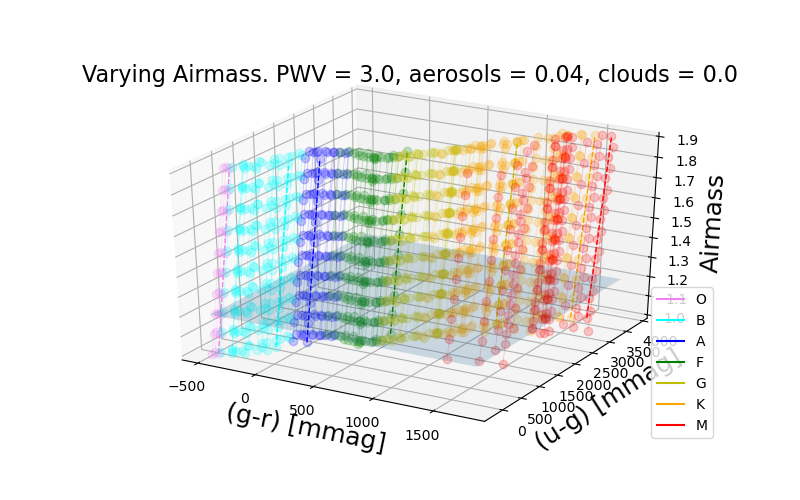

In [39]:

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='3d')

cy = 'u-g'
cx = 'g-r'

minc1 = []
maxc1 = []
minc2 = []
maxc2 = []
for spec_type in spectral_types:
    for si in am_color_dict[spec_type]:
        c1 = am_color_dict[spec_type][si][cx.lower()]*1000.
        c2 = am_color_dict[spec_type][si][cy.lower()]*1000.
        
        c1_ref = am_color_ref_dict[spec_type][si][cx.lower()]*1000.
        c2_ref = am_color_ref_dict[spec_type][si][cy.lower()]*1000.
        
        minc1.append(np.min(c1))
        maxc1.append(np.max(c1))
        minc2.append(np.min(c2))
        maxc2.append(np.max(c2))
        
        #ax.scatter(c1,c2,pwv_vals,c=type_colors[spec_type],marker='o',s=msize,alpha=1.0,zorder=1)
        ax.plot(c1,c2,am_vals,ls='-',linewidth=0.6,marker='o',color=type_colors[spec_type],alpha=0.2,zorder=-1)
    params1 = am_model_dict[(spec_type,cx.lower())]
    params2 = am_model_dict[(spec_type,cy.lower())]
    model1 = lin_fun(am_vals,params1[0],params1[1])*1000.
    model2 = lin_fun(am_vals,params2[0],params2[1])*1000.
    ax.plot(model1+c1_ref,model2+c2_ref,am_vals,ls='--',linewidth=1.0,marker='',color=type_colors[spec_type],alpha=1.0,zorder=-1)
    
    
for spec_type in spectral_types:
    ax.plot([],[],[],c=type_colors[spec_type],ls='-',marker='',label=spec_type)
    

X, Y = np.meshgrid(np.linspace(np.min(minc1),np.max(maxc1),100), np.linspace(np.min(minc2),np.max(maxc2),100))
Z = np.ones(X.shape)*am0
ax.plot_surface(X, Y, Z, alpha=0.2)

ax.grid()
ax.set_xlabel('('+cx+') [mmag]',fontsize=18)
ax.set_ylabel('('+cy+') [mmag]',fontsize=18)
ax.set_zlabel('Airmass',fontsize=18)
ax.set_title('Varying {0}. PWV = {1}, aerosols = {2}, clouds = {3}'.format('Airmass',pwv0,aero0,cloud0),fontsize=16)
ax.legend(loc='lower right',fontsize=10)


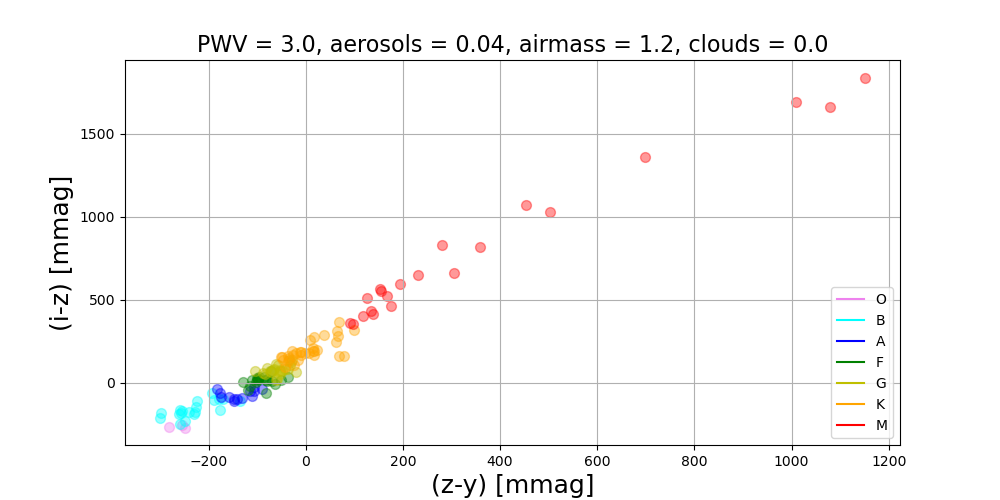

In [40]:

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

cy = 'i-z'
cx = 'z-y'

for spec_type in spectral_types:
    for si in pwv_color_dict[spec_type]:
        c1_ref = pwv_color_ref_dict[spec_type][si][cx.lower()]*1000.
        c2_ref = pwv_color_ref_dict[spec_type][si][cy.lower()]*1000.
        
        ax.scatter(c1_ref,c2_ref,c=type_colors[spec_type],marker='o',s=50.,alpha=0.4,zorder=1)
        #ax.plot(c1_ref,c2_ref,ls='-',linewidth=0.6,marker='o',color=type_colors[spec_type],alpha=0.2,zorder=-1)
    
for spec_type in spectral_types:
    ax.plot([],[],c=type_colors[spec_type],ls='-',marker='',label=spec_type)
    

ax.grid()
#ax.set_xticks(fontsize=20)
#ax.set_yticks(fontsize=20)
#ax.set_xlim(-100.,60.)#################
#ax.set_ylim(-35.,15.)#################
        
ax.set_xlabel('('+cx+') [mmag]',fontsize=18)
ax.set_ylabel('('+cy+') [mmag]',fontsize=18)
ax.set_title('PWV = {0}, aerosols = {1}, airmass = {2}, clouds = {3}'.format(pwv0,aero0,am0,cloud0),fontsize=16)
ax.legend(loc='lower right',fontsize=10)


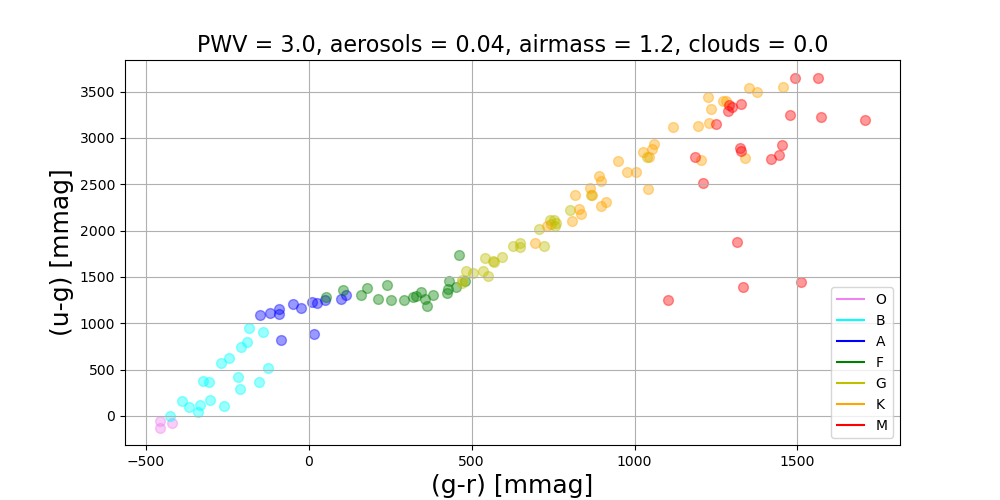

In [41]:

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

cy = 'u-g'
cx = 'g-r'

for spec_type in spectral_types:
    for si in pwv_color_dict[spec_type]:
        c1_ref = pwv_color_ref_dict[spec_type][si][cx.lower()]*1000.
        c2_ref = pwv_color_ref_dict[spec_type][si][cy.lower()]*1000.
        
        ax.scatter(c1_ref,c2_ref,c=type_colors[spec_type],marker='o',s=50.,alpha=0.4,zorder=1)
        #ax.plot(c1_ref,c2_ref,ls='-',linewidth=0.6,marker='o',color=type_colors[spec_type],alpha=0.2,zorder=-1)
    
for spec_type in spectral_types:
    ax.plot([],[],c=type_colors[spec_type],ls='-',marker='',label=spec_type)
    

ax.grid()
#ax.set_xticks(fontsize=20)
#ax.set_yticks(fontsize=20)
#ax.set_xlim(-100.,60.)#################
#ax.set_ylim(-35.,15.)#################
        
ax.set_xlabel('('+cx+') [mmag]',fontsize=18)
ax.set_ylabel('('+cy+') [mmag]',fontsize=18)
ax.set_title('PWV = {0}, aerosols = {1}, airmass = {2}, clouds = {3}'.format(pwv0,aero0,am0,cloud0),fontsize=16)
ax.legend(loc='lower right',fontsize=10)


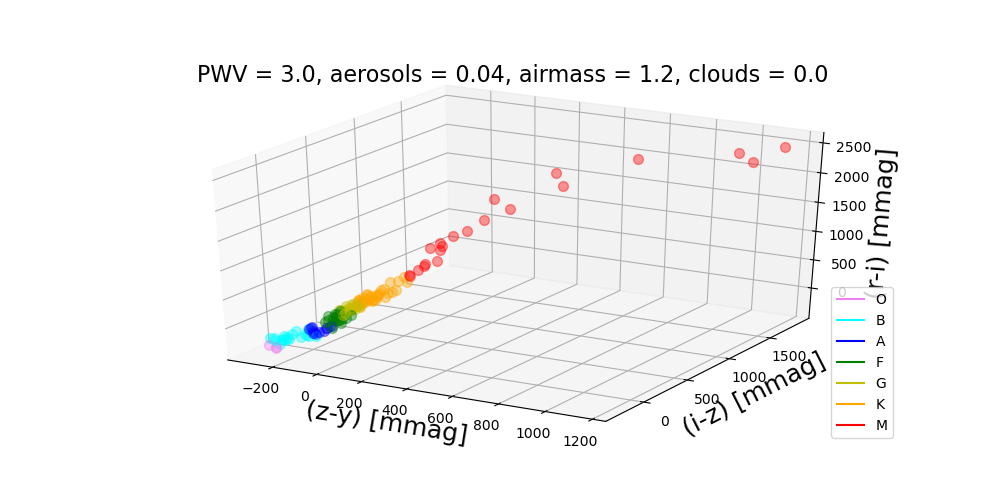

In [42]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection='3d')

cz = 'r-i'
cy = 'i-z'
cx = 'z-y'

for spec_type in spectral_types:
    for si in pwv_color_dict[spec_type]:
        c1_ref = pwv_color_ref_dict[spec_type][si][cx.lower()]*1000.
        c2_ref = pwv_color_ref_dict[spec_type][si][cy.lower()]*1000.
        c3_ref = pwv_color_ref_dict[spec_type][si][cz.lower()]*1000.
        
        ax.scatter(c1_ref,c2_ref,c3_ref,c=type_colors[spec_type],marker='o',s=50.,alpha=0.4,zorder=1)
        #ax.plot(c1_ref,c2_ref,ls='-',linewidth=0.6,marker='o',color=type_colors[spec_type],alpha=0.2,zorder=-1)
    
for spec_type in spectral_types:
    ax.plot([],[],[],c=type_colors[spec_type],ls='-',marker='',label=spec_type)
    

ax.grid()
#ax.set_xticks(fontsize=20)
#ax.set_yticks(fontsize=20)
#ax.set_xlim(-100.,60.)#################
#ax.set_ylim(-35.,15.)#################
        
ax.set_xlabel('('+cx+') [mmag]',fontsize=18)
ax.set_ylabel('('+cy+') [mmag]',fontsize=18)
ax.set_zlabel('('+cz+') [mmag]',fontsize=18)
ax.set_title('PWV = {0}, aerosols = {1}, airmass = {2}, clouds = {3}'.format(pwv0,aero0,am0,cloud0),fontsize=16)
ax.legend(loc='lower right',fontsize=10)

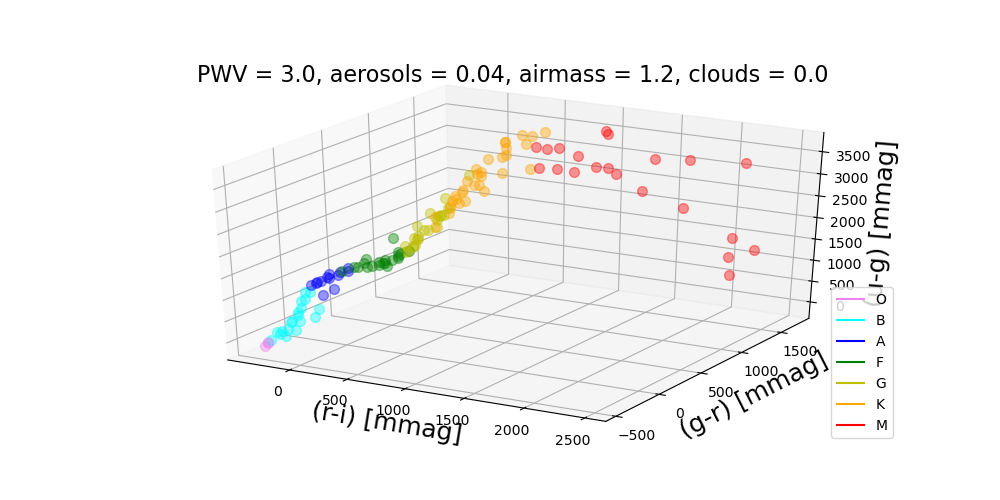

In [43]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection='3d')

cz = 'u-g'
cy = 'g-r'
cx = 'r-i'

for spec_type in spectral_types:
    for si in pwv_color_dict[spec_type]:
        c1_ref = pwv_color_ref_dict[spec_type][si][cx.lower()]*1000.
        c2_ref = pwv_color_ref_dict[spec_type][si][cy.lower()]*1000.
        c3_ref = pwv_color_ref_dict[spec_type][si][cz.lower()]*1000.
        
        ax.scatter(c1_ref,c2_ref,c3_ref,c=type_colors[spec_type],marker='o',s=50.,alpha=0.4,zorder=1)
        #ax.plot(c1_ref,c2_ref,ls='-',linewidth=0.6,marker='o',color=type_colors[spec_type],alpha=0.2,zorder=-1)
    
for spec_type in spectral_types:
    ax.plot([],[],[],c=type_colors[spec_type],ls='-',marker='',label=spec_type)
    

ax.grid()
#ax.set_xticks(fontsize=20)
#ax.set_yticks(fontsize=20)
#ax.set_xlim(-100.,60.)#################
#ax.set_ylim(-35.,15.)#################
        
ax.set_xlabel('('+cx+') [mmag]',fontsize=18)
ax.set_ylabel('('+cy+') [mmag]',fontsize=18)
ax.set_zlabel('('+cz+') [mmag]',fontsize=18)
ax.set_title('PWV = {0}, aerosols = {1}, airmass = {2}, clouds = {3}'.format(pwv0,aero0,am0,cloud0),fontsize=16)
ax.legend(loc='lower right',fontsize=10)

# Ongoing work 

We have used the stellar types as an approach to evaluate the dependance of the color corrections with the SED of the sources. But we need to keep in mind that with LSST we won't have SEDs, but a magnitude vector, $\vec{m} = (u,g,r,i,z,Y)$, and therefore a color vector, $\vec{c}$. For this reason, we need to work on magnitude/color space. Our current work is to investigate an object clasification in color space to better determine the necessary color corrections 

If you are interested, JOIN US! 

Contact us by email or on slack: 
* Marc Moniez (marc.moniez@ijclab.in2p3.fr)
* Sylvie Dagoret-Campagne (sylvie.dagoret-campagne@ijclab.in2p3.fr)
* Martín Rodríguez Monroy (martin.rodriguez-monroy@ijclab.in2p3.fr)



# Now, we are going to look at the color-color plots as a function of two variables simultaneously 

First, we recover the 2D color-color plots as a function of PWV and of aerosols (separately) 

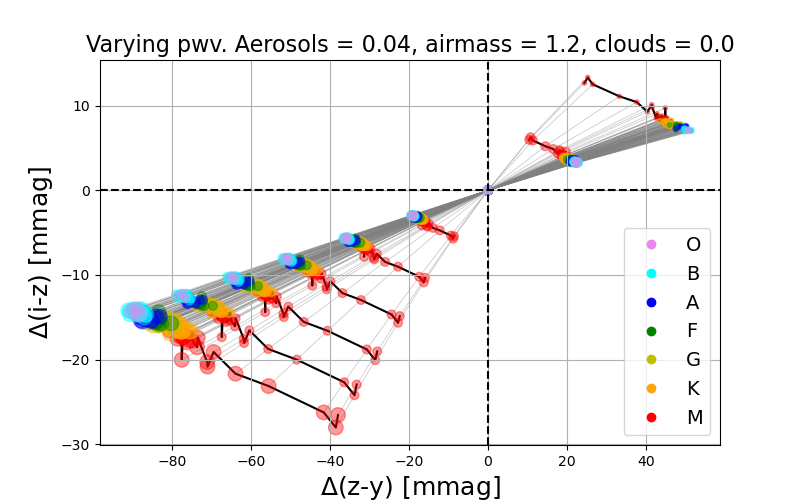

In [44]:
variable_param = 'pwv'

colour_dict = eval('{0}_color_dict'.format(variable_param))
colour_dict_ref = eval('{0}_color_ref_dict'.format(variable_param))

fig_rows = len(filters)-2

fig, axs = plt.subplots(1, 1, figsize=(8,5))
cy = 'i-z'
cx = 'z-y'

iso_vals1 = []
iso_vals2 = []
for spec_type in spectral_types[::-1]:
    for si in colour_dict[spec_type]:
        delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
        delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
        msize = [10.]
        msize = msize+[40.]*(len(delta1)-2)
        msize.append(110.)

        iso_vals1.append(delta1)
        iso_vals2.append(delta2)

        axs.scatter(delta1,delta2,c=type_colors[spec_type],marker='o',s=msize,alpha=0.4,zorder=1)
        axs.plot(delta1,delta2,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
for spec_type in spectral_types:
    axs.plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
'''    
for sn in sn_colour_dict.keys():
        delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
        delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
        msize = [10.]
        msize = msize+[40.]*(len(delta1)-2)
        msize.append(110.)

        iso_vals1.append(delta1_sn)
        iso_vals2.append(delta2_sn)

        axs.scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
        axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
axs.plot([],[],c='k',ls='',marker='o',label='SNe Ia')    

delta1_flat = (flat_colour_dict[cx.lower()]-flat_colour_dict_ref[cx.lower()])*1000.
delta2_flat = (flat_colour_dict[cy.lower()]-flat_colour_dict_ref[cy.lower()])*1000.
axs.scatter(delta1_flat,delta2_flat,c='k',marker='s',s=msize)
axs.plot(delta1_flat,delta2_flat,ls='-',linewidth=2.0,marker='',color='k',alpha=1.0,zorder=1)
axs.plot([],[],c='k',ls='-',marker='s',label='AB spec')
'''

iso_vals1 = np.array(iso_vals1)
iso_vals2 = np.array(iso_vals2)
for val in range(iso_vals1.shape[1]):
    #print(iso_vals1[:,val])
    sort_index = np.argsort(iso_vals1[:,val])
    axs.plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)

axs.axhline(y=0.,ls='--',color='k')
axs.axvline(x=0.,ls='--',color='k')
axs.grid()
#axs.set_xticks(fontsize=20)
#axs.set_yticks(fontsize=20)
#axs.set_xlim(rangey2)#################
#axs.set_ylim(rangex2)#################

axs.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
axs.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
axs.set_title('Varying {0}. Aerosols = {1}, airmass = {2}, clouds = {3}'.format(variable_param,aero0,am0,cloud0),fontsize=16)
axs.legend(fontsize=14)


del fig, axs

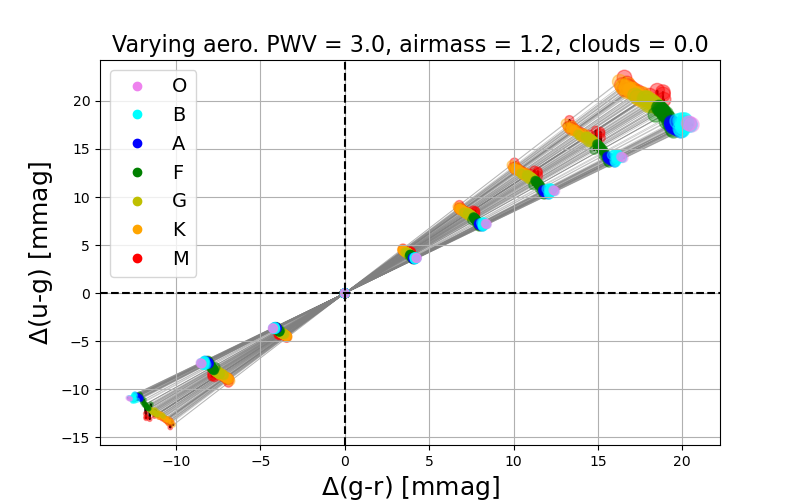

In [45]:
variable_param = 'aero'

colour_dict = eval('{0}_color_dict'.format(variable_param))
colour_dict_ref = eval('{0}_color_ref_dict'.format(variable_param))

fig_rows = len(filters)-2

fig, axs = plt.subplots(1, 1, figsize=(8,5))
cy = 'u-g'
cx = 'g-r'

iso_vals1 = []
iso_vals2 = []
for spec_type in spectral_types[::-1]:
    for si in colour_dict[spec_type]:
        delta1 = (colour_dict[spec_type][si][cx.lower()]-colour_dict_ref[spec_type][si][cx.lower()])*1000.
        delta2 = (colour_dict[spec_type][si][cy.lower()]-colour_dict_ref[spec_type][si][cy.lower()])*1000.
        msize = [10.]
        msize = msize+[40.]*(len(delta1)-2)
        msize.append(110.)

        iso_vals1.append(delta1)
        iso_vals2.append(delta2)

        axs.scatter(delta1,delta2,c=type_colors[spec_type],marker='o',s=msize,alpha=0.4,zorder=1)
        axs.plot(delta1,delta2,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
for spec_type in spectral_types:
    axs.plot([],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
'''    
for sn in sn_colour_dict.keys():
        delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
        delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
        msize = [10.]
        msize = msize+[40.]*(len(delta1)-2)
        msize.append(110.)

        iso_vals1.append(delta1_sn)
        iso_vals2.append(delta2_sn)

        axs.scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
        axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
axs.plot([],[],c='k',ls='',marker='o',label='SNe Ia')    

delta1_flat = (flat_colour_dict[cx.lower()]-flat_colour_dict_ref[cx.lower()])*1000.
delta2_flat = (flat_colour_dict[cy.lower()]-flat_colour_dict_ref[cy.lower()])*1000.
axs.scatter(delta1_flat,delta2_flat,c='k',marker='s',s=msize)
axs.plot(delta1_flat,delta2_flat,ls='-',linewidth=2.0,marker='',color='k',alpha=1.0,zorder=1)
axs.plot([],[],c='k',ls='-',marker='s',label='AB spec')
'''

iso_vals1 = np.array(iso_vals1)
iso_vals2 = np.array(iso_vals2)
for val in range(iso_vals1.shape[1]):
    #print(iso_vals1[:,val])
    sort_index = np.argsort(iso_vals1[:,val])
    axs.plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],ls='-',marker='',color='k',zorder=-1)

axs.axhline(y=0.,ls='--',color='k')
axs.axvline(x=0.,ls='--',color='k')
axs.grid()
#axs.set_xticks(fontsize=20)
#axs.set_yticks(fontsize=20)
#axs.set_xlim(rangey2)#################
#axs.set_ylim(rangex2)#################

axs.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
axs.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
axs.set_title('Varying {0}. PWV = {1}, airmass = {2}, clouds = {3}'.format(variable_param,pwv0,am0,cloud0),fontsize=16)
axs.legend(fontsize=14)


del fig, axs

### Now, we look at the 3D plots, that is the color-color plot as a function of PWV/aerosols and airmass 

PWV and airmass 

/tmp/ipykernel_132288/3892019604.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8,5))


1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9


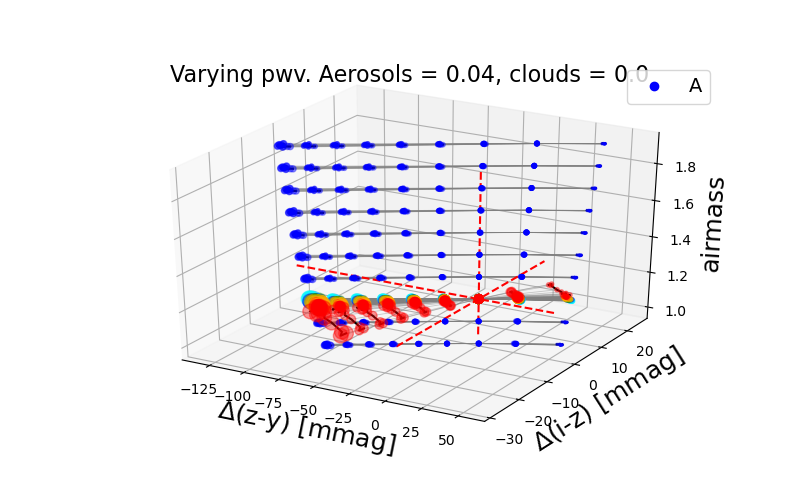

In [46]:
variable_param = 'pwv'
test_types = ['A']

fig = plt.figure(figsize=(8,5))
axs = fig.add_subplot(projection='3d')

cy = 'i-z'
cx = 'z-y'

colour_ref_dict_ = np.load(os.path.join(input_dir,color_ref_file).format(variable_param,am0,cloud0),allow_pickle=True).ravel()[0]

xmin = []
xmax = []
ymin = []
ymax = []
for am in am_vals:
    print(am)
    colour_dict_ = np.load(os.path.join(input_dir,color_file.format(variable_param,am,cloud0)),allow_pickle=True).ravel()[0]
    #colour_ref_dict_ = np.load(os.path.join(input_dir,color_ref_file).format('pwv',am0,cloud0),allow_pickle=True).ravel()[0]

    iso_vals1 = []
    iso_vals2 = []
    
    if am==am0:
        spectral_types_ = spectral_types[::-1]
        #spectral_types_ = test_types
    else:
        spectral_types_ = test_types
    for spec_type in spectral_types_:
        for si in colour_dict_[spec_type]:
            delta1 = (colour_dict_[spec_type][si][cx.lower()]-colour_ref_dict_[spec_type][si][cx.lower()])*1000.
            delta2 = (colour_dict_[spec_type][si][cy.lower()]-colour_ref_dict_[spec_type][si][cy.lower()])*1000.
            if am==am0:
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
            else:
                msize = [2.]
                msize = msize+[10.]*(len(delta1)-2)
                msize.append(20.)

            iso_vals1.append(delta1)
            iso_vals2.append(delta2)
            
            xmin.append(np.min(delta1))
            xmax.append(np.max(delta1))
            ymin.append(np.min(delta2))
            ymax.append(np.max(delta2))

            axs.scatter(delta1,delta2,am,c=type_colors[spec_type],marker='o',s=msize,alpha=0.4,zorder=1)
            axs.plot(delta1,delta2,am,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
    
    '''    
    for sn in sn_colour_dict.keys():
            delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
            delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
            msize = [10.]
            msize = msize+[40.]*(len(delta1)-2)
            msize.append(110.)

            iso_vals1.append(delta1_sn)
            iso_vals2.append(delta2_sn)

            axs.scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
            axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
    axs.plot([],[],c='k',ls='',marker='o',label='SNe Ia')    

    delta1_flat = (flat_colour_dict[cx.lower()]-flat_colour_dict_ref[cx.lower()])*1000.
    delta2_flat = (flat_colour_dict[cy.lower()]-flat_colour_dict_ref[cy.lower()])*1000.
    axs.scatter(delta1_flat,delta2_flat,c='k',marker='s',s=msize)
    axs.plot(delta1_flat,delta2_flat,ls='-',linewidth=2.0,marker='',color='k',alpha=1.0,zorder=1)
    axs.plot([],[],c='k',ls='-',marker='s',label='AB spec')
    '''

    iso_vals1 = np.array(iso_vals1)
    iso_vals2 = np.array(iso_vals2)
    for val in range(iso_vals1.shape[1]):
        #print(iso_vals1[:,val])
        sort_index = np.argsort(iso_vals1[:,val])
        axs.plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],am,ls='-',marker='',color='k',zorder=-1)

for spec_type in spectral_types_:
    axs.plot([],[],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
#axs.axhline(y=0.,ls='--',color='r')
#axs.axvline(x=0.,ls='--',color='r')

xmin = np.array(xmin)
xmax = np.array(xmax)
ymin = np.array(ymin)
ymin = np.array(ymin)

xrange = np.linspace(np.min(xmin),np.max(xmax),100)
yrange = np.linspace(np.min(ymin),np.max(ymax),100)
zrange = np.linspace(np.min(am_vals),np.max(am_vals),100)

axs.plot(xrange,np.zeros(len(yrange)),np.ones(len(zrange))*am0,'r--')
axs.plot(np.zeros(len(xrange)),yrange,np.ones(len(zrange))*am0,'r--')
axs.plot(np.zeros(len(xrange)),np.zeros(len(yrange)),zrange,'r--')


axs.grid()
#axs.set_xticks(fontsize=20)
#axs.set_yticks(fontsize=20)
#axs.set_xlim(rangey2)#################
#axs.set_ylim(rangex2)#################

axs.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
axs.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
axs.set_zlabel('airmass',fontsize=18)
axs.set_title('Varying {0}. Aerosols = {1}, clouds = {2}'.format(variable_param,aero0,cloud0),fontsize=16)
axs.legend(fontsize=14)



del fig, axs

Aerosols and airmass 

/tmp/ipykernel_132288/2410441257.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8,5))


1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9


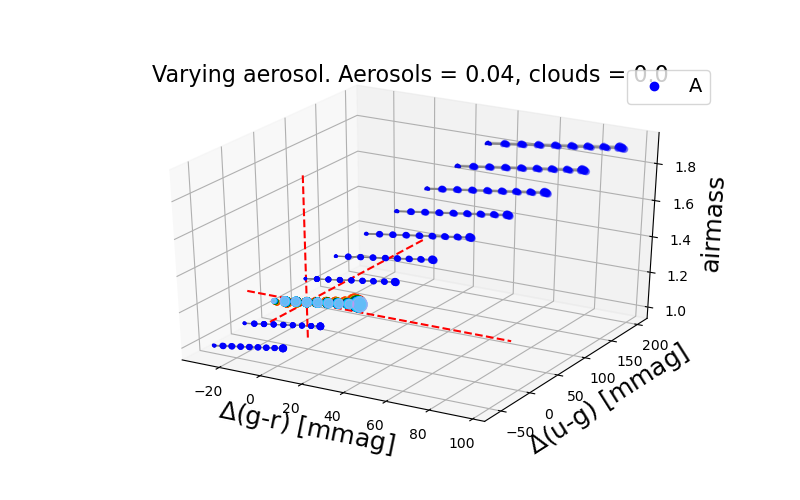

In [47]:
variable_param = 'aerosol'
test_types = ['A']

fig = plt.figure(figsize=(8,5))
axs = fig.add_subplot(projection='3d')

cy = 'u-g'
cx = 'g-r'

colour_ref_dict_ = np.load(os.path.join(input_dir,color_ref_file).format(variable_param,am0,cloud0),allow_pickle=True).ravel()[0]

xmin = []
xmax = []
ymin = []
ymax = []
for am in am_vals:
    print(am)
    colour_dict_ = np.load(os.path.join(input_dir,color_file.format(variable_param,am,cloud0)),allow_pickle=True).ravel()[0]
    #colour_ref_dict_ = np.load(os.path.join(input_dir,color_ref_file).format('pwv',am0,cloud0),allow_pickle=True).ravel()[0]

    iso_vals1 = []
    iso_vals2 = []
    
    if am==am0:
        spectral_types_ = spectral_types[::-1]
        #spectral_types_ = test_types
    else:
        spectral_types_ = test_types
    for spec_type in spectral_types_:
        for si in colour_dict_[spec_type]:
            delta1 = (colour_dict_[spec_type][si][cx.lower()]-colour_ref_dict_[spec_type][si][cx.lower()])*1000.
            delta2 = (colour_dict_[spec_type][si][cy.lower()]-colour_ref_dict_[spec_type][si][cy.lower()])*1000.
            if am==am0:
                msize = [10.]
                msize = msize+[40.]*(len(delta1)-2)
                msize.append(110.)
            else:
                msize = [2.]
                msize = msize+[10.]*(len(delta1)-2)
                msize.append(20.)

            iso_vals1.append(delta1)
            iso_vals2.append(delta2)
            
            xmin.append(np.min(delta1))
            xmax.append(np.max(delta1))
            ymin.append(np.min(delta2))
            ymax.append(np.max(delta2))

            axs.scatter(delta1,delta2,am,c=type_colors[spec_type],marker='o',s=msize,alpha=0.4,zorder=1)
            axs.plot(delta1,delta2,am,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
    
    '''    
    for sn in sn_colour_dict.keys():
            delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
            delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
            msize = [10.]
            msize = msize+[40.]*(len(delta1)-2)
            msize.append(110.)

            iso_vals1.append(delta1_sn)
            iso_vals2.append(delta2_sn)

            axs.scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
            axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
    axs.plot([],[],c='k',ls='',marker='o',label='SNe Ia')    

    delta1_flat = (flat_colour_dict[cx.lower()]-flat_colour_dict_ref[cx.lower()])*1000.
    delta2_flat = (flat_colour_dict[cy.lower()]-flat_colour_dict_ref[cy.lower()])*1000.
    axs.scatter(delta1_flat,delta2_flat,c='k',marker='s',s=msize)
    axs.plot(delta1_flat,delta2_flat,ls='-',linewidth=2.0,marker='',color='k',alpha=1.0,zorder=1)
    axs.plot([],[],c='k',ls='-',marker='s',label='AB spec')
    '''

    iso_vals1 = np.array(iso_vals1)
    iso_vals2 = np.array(iso_vals2)
    for val in range(iso_vals1.shape[1]):
        #print(iso_vals1[:,val])
        sort_index = np.argsort(iso_vals1[:,val])
        axs.plot(iso_vals1[:,val][sort_index],iso_vals2[:,val][sort_index],am,ls='-',marker='',color='k',zorder=-1)

for spec_type in spectral_types_:
    axs.plot([],[],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
#axs.axhline(y=0.,ls='--',color='r')
#axs.axvline(x=0.,ls='--',color='r')

xmin = np.array(xmin)
xmax = np.array(xmax)
ymin = np.array(ymin)
ymin = np.array(ymin)

xrange = np.linspace(np.min(xmin),np.max(xmax),100)
yrange = np.linspace(np.min(ymin),np.max(ymax),100)
zrange = np.linspace(np.min(am_vals),np.max(am_vals),100)

axs.plot(xrange,np.zeros(len(yrange)),np.ones(len(zrange))*am0,'r--')
axs.plot(np.zeros(len(xrange)),yrange,np.ones(len(zrange))*am0,'r--')
axs.plot(np.zeros(len(xrange)),np.zeros(len(yrange)),zrange,'r--')


axs.grid()
#axs.set_xticks(fontsize=20)
#axs.set_yticks(fontsize=20)
#axs.set_xlim(rangey2)#################
#axs.set_ylim(rangex2)#################

axs.set_xlabel(r'$\Delta$'+'('+cx+') [mmag]',fontsize=18)
axs.set_ylabel(r'$\Delta$'+'('+cy+') [mmag]',fontsize=18)
axs.set_zlabel('airmass',fontsize=18)
axs.set_title('Varying {0}. Aerosols = {1}, clouds = {2}'.format(variable_param,aero0,cloud0),fontsize=16)
axs.legend(fontsize=14)



del fig, axs

## Now, instead of looking at the color-color space, let's look at the evolution of one color as a function of PWV/aerosols and airmass 

This is important to look at the $\Delta c^{xy}$ dependency with each variable and also evaluate the correlation between these 

$\Delta c^{xy}$ vs PWV and airmass 

1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8


/tmp/ipykernel_132288/2096479867.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8,5))


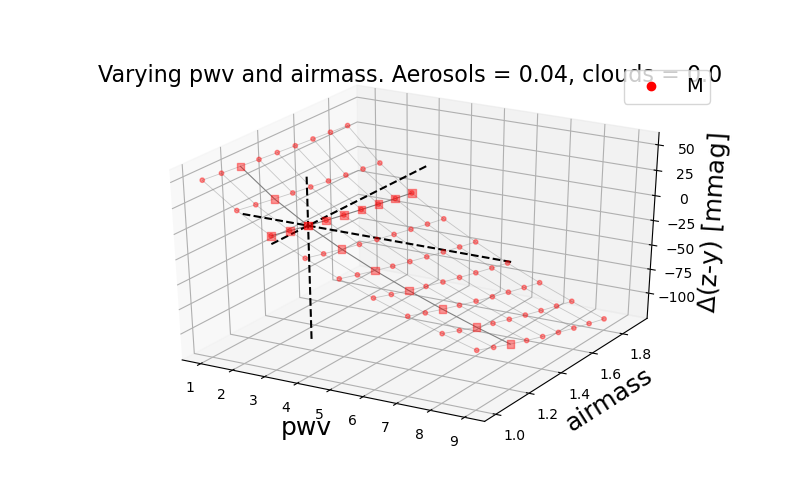

In [48]:
variable_param = 'pwv'
test_types = ['M']
test_spec = 0

if variable_param=='aerosol':
    var_short = 'aero'
else:
    var_short = variable_param

fig = plt.figure(figsize=(8,5))
axs = fig.add_subplot(projection='3d')

c_ = 'z-y'

colour_ref_dict_ = np.load(os.path.join(input_dir,color_ref_file).format(variable_param,am0,cloud0),allow_pickle=True).ravel()[0]

p_vals = eval('{0}_vals'.format(var_short))
p0 = eval('{0}0'.format(var_short))

zmin = []
zmax = []
mesh = {}

for spec_type in test_types:
    mesh[spec_type] = []

for am in am_vals[:len(p_vals)]:
    print(am)
    colour_dict_ = np.load(os.path.join(input_dir,color_file.format(variable_param,am,cloud0)),allow_pickle=True).ravel()[0]
    #colour_ref_dict_ = np.load(os.path.join(input_dir,color_ref_file).format('pwv',am0,cloud0),allow_pickle=True).ravel()[0]
    
    am_vals_ = np.ones(len(p_vals))*am
    
    for spec_type in test_types:
        for si in colour_dict_[spec_type]:
            if si==test_spec:
                delta_ = (colour_dict_[spec_type][si][c_.lower()]-colour_ref_dict_[spec_type][si][c_.lower()])*1000.
                
                mesh[spec_type].append(delta_)
                zmin.append(np.min(delta_))
                zmax.append(np.max(delta_))
                
                if am==am0:
                    marker = 's'
                    marker_size = 30.
                    alpha = 1.0
                    linewidth = 0.8
                else:
                    marker = 'o'
                    marker_size = 10.
                    alpha = 0.4
                    linewidth = 0.6
                
                axs.scatter(p_vals,am_vals_,delta_,c=type_colors[spec_type],marker=marker,s=marker_size,alpha=0.4,zorder=1)
                axs.plot(p_vals,am_vals_,delta_,ls='-',linewidth=linewidth,marker='',color='grey',alpha=alpha,zorder=-1)
    
    '''    
    for sn in sn_colour_dict.keys():
            delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
            delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
            msize = [10.]
            msize = msize+[40.]*(len(delta1)-2)
            msize.append(110.)

            iso_vals1.append(delta1_sn)
            iso_vals2.append(delta2_sn)

            axs.scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
            axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
    axs.plot([],[],c='k',ls='',marker='o',label='SNe Ia')    

    delta1_flat = (flat_colour_dict[cx.lower()]-flat_colour_dict_ref[cx.lower()])*1000.
    delta2_flat = (flat_colour_dict[cy.lower()]-flat_colour_dict_ref[cy.lower()])*1000.
    axs.scatter(delta1_flat,delta2_flat,c='k',marker='s',s=msize)
    axs.plot(delta1_flat,delta2_flat,ls='-',linewidth=2.0,marker='',color='k',alpha=1.0,zorder=1)
    axs.plot([],[],c='k',ls='-',marker='s',label='AB spec')
    '''
    
zmin = np.array(zmin)
zmax = np.array(zmax)

for spec_type in test_types:
    for iso_ in range(np.array(mesh[spec_type]).shape[1]):
        x_ = np.ones(np.array(mesh[spec_type]).shape[1])*p_vals[iso_]
        y_ = am_vals[:len(p_vals)]
        z_ = np.array(mesh[spec_type])[:,iso_]
        if iso_==np.where(p_vals==p0)[0][0]:
            axs.plot(x_,y_,z_,ls='-',linewidth=0.8,color='grey',alpha=1.0)
            axs.scatter(x_,y_,z_,marker='s',s=30.,color=type_colors[spec_type],alpha=0.4)
        else:
            axs.plot(x_,y_,z_,ls='-',linewidth=0.6,color='grey',alpha=0.4)

for spec_type in test_types:
    axs.plot([],[],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
#axs.axhline(y=0.,ls='--',color='r')
#axs.axvline(x=0.,ls='--',color='r')


xrange = np.linspace(np.min(p_vals),np.max(p_vals),100)
yrange = np.linspace(np.min(am_vals),np.max(am_vals),100)
zrange = np.linspace(np.min(zmin),np.max(zmax),100)

axs.plot(xrange,np.ones(len(yrange))*am0,np.zeros(len(zrange)),'k--')
axs.plot(np.ones(len(xrange))*p0,yrange,np.zeros(len(zrange)),'k--')
axs.plot(np.ones(len(xrange))*p0,np.ones(len(yrange))*am0,zrange,'k--')


axs.grid()
#axs.set_xticks(fontsize=20)
#axs.set_yticks(fontsize=20)
#axs.set_xlim(rangey2)#################
#axs.set_ylim(rangex2)#################

axs.set_xlabel(variable_param,fontsize=18)
axs.set_ylabel('airmass',fontsize=18)
axs.set_zlabel(r'$\Delta$'+'('+c_+') [mmag]',fontsize=18)
axs.set_title('Varying {0} and airmass. Aerosols = {1}, clouds = {2}'.format(variable_param,aero0,cloud0),fontsize=16)
axs.legend(fontsize=14)



del fig, axs

$\Delta c^{xy}$ vs aerosols and airmass 

/tmp/ipykernel_132288/3009475688.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8,5))


1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8


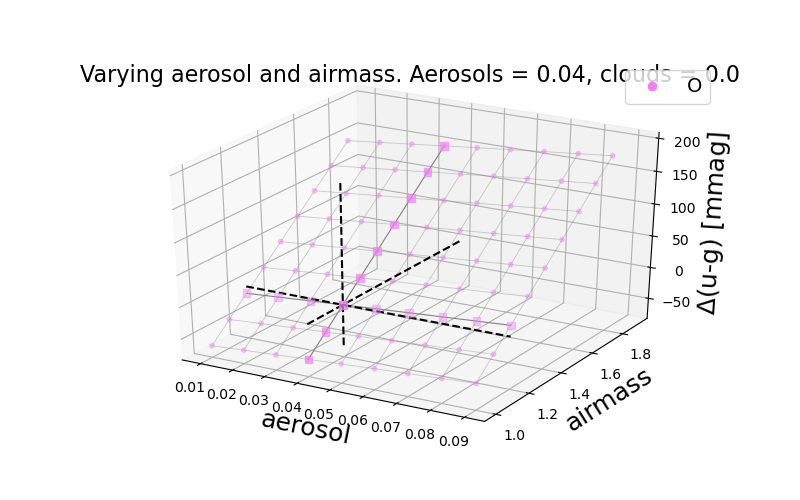

In [49]:
variable_param = 'aerosol'
test_types = ['O']
test_spec = 0

if variable_param=='aerosol':
    var_short = 'aero'
else:
    var_short = variable_param

fig = plt.figure(figsize=(8,5))
axs = fig.add_subplot(projection='3d')

c_ = 'u-g'

colour_ref_dict_ = np.load(os.path.join(input_dir,color_ref_file).format(variable_param,am0,cloud0),allow_pickle=True).ravel()[0]

p_vals = eval('{0}_vals'.format(var_short))
p0 = eval('{0}0'.format(var_short))

zmin = []
zmax = []
mesh = {}

for spec_type in test_types:
    mesh[spec_type] = []

for am in am_vals[:len(p_vals)]:
    print(am)
    colour_dict_ = np.load(os.path.join(input_dir,color_file.format(variable_param,am,cloud0)),allow_pickle=True).ravel()[0]
    #colour_ref_dict_ = np.load(os.path.join(input_dir,color_ref_file).format('pwv',am0,cloud0),allow_pickle=True).ravel()[0]
    
    am_vals_ = np.ones(len(p_vals))*am
    
    for spec_type in test_types:
        for si in colour_dict_[spec_type]:
            if si==test_spec:
                delta_ = (colour_dict_[spec_type][si][c_.lower()]-colour_ref_dict_[spec_type][si][c_.lower()])*1000.
                
                mesh[spec_type].append(delta_)
                zmin.append(np.min(delta_))
                zmax.append(np.max(delta_))
                
                if am==am0:
                    marker = 's'
                    marker_size = 30.
                    alpha = 1.0
                    linewidth = 0.8
                else:
                    marker = 'o'
                    marker_size = 10.
                    alpha = 0.4
                    linewidth = 0.6
                
                axs.scatter(p_vals,am_vals_,delta_,c=type_colors[spec_type],marker=marker,s=marker_size,alpha=0.4,zorder=1)
                axs.plot(p_vals,am_vals_,delta_,ls='-',linewidth=linewidth,marker='',color='grey',alpha=alpha,zorder=-1)
    
    '''    
    for sn in sn_colour_dict.keys():
            delta1_sn = (sn_colour_dict[sn][cx.lower()]-sn_colour_dict_ref[sn][cx.lower()])*1000.
            delta2_sn = (sn_colour_dict[sn][cy.lower()]-sn_colour_dict_ref[sn][cy.lower()])*1000.
            msize = [10.]
            msize = msize+[40.]*(len(delta1)-2)
            msize.append(110.)

            iso_vals1.append(delta1_sn)
            iso_vals2.append(delta2_sn)

            axs.scatter(delta1_sn,delta2_sn,c='k',marker='o',s=msize)
            axs.plot(delta1_sn,delta2_sn,ls='-',linewidth=0.6,marker='',color='grey',alpha=0.4,zorder=-1)
    axs.plot([],[],c='k',ls='',marker='o',label='SNe Ia')    

    delta1_flat = (flat_colour_dict[cx.lower()]-flat_colour_dict_ref[cx.lower()])*1000.
    delta2_flat = (flat_colour_dict[cy.lower()]-flat_colour_dict_ref[cy.lower()])*1000.
    axs.scatter(delta1_flat,delta2_flat,c='k',marker='s',s=msize)
    axs.plot(delta1_flat,delta2_flat,ls='-',linewidth=2.0,marker='',color='k',alpha=1.0,zorder=1)
    axs.plot([],[],c='k',ls='-',marker='s',label='AB spec')
    '''
    
zmin = np.array(zmin)
zmax = np.array(zmax)

for spec_type in test_types:
    for iso_ in range(np.array(mesh[spec_type]).shape[1]):
        x_ = np.ones(np.array(mesh[spec_type]).shape[1])*p_vals[iso_]
        y_ = am_vals[:len(p_vals)]
        z_ = np.array(mesh[spec_type])[:,iso_]
        if iso_==np.where(p_vals==p0)[0][0]:
            axs.plot(x_,y_,z_,ls='-',linewidth=0.8,color='grey',alpha=1.0)
            axs.scatter(x_,y_,z_,marker='s',s=30.,color=type_colors[spec_type],alpha=0.6)
        else:
            axs.plot(x_,y_,z_,ls='-',linewidth=0.6,color='grey',alpha=0.4)
        
for spec_type in test_types:
    axs.plot([],[],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
#axs.axhline(y=0.,ls='--',color='r')
#axs.axvline(x=0.,ls='--',color='r')


xrange = np.linspace(np.min(p_vals),np.max(p_vals),100)
yrange = np.linspace(np.min(am_vals),np.max(am_vals),100)
zrange = np.linspace(np.min(zmin),np.max(zmax),100)

axs.plot(xrange,np.ones(len(yrange))*am0,np.zeros(len(zrange)),'k--')
axs.plot(np.ones(len(xrange))*p0,yrange,np.zeros(len(zrange)),'k--')
axs.plot(np.ones(len(xrange))*p0,np.ones(len(yrange))*am0,zrange,'k--')


axs.grid()
#axs.set_xticks(fontsize=20)
#axs.set_yticks(fontsize=20)
#axs.set_xlim(rangey2)#################
#axs.set_ylim(rangex2)#################

axs.set_xlabel(variable_param,fontsize=18)
axs.set_ylabel('airmass',fontsize=18)
axs.set_zlabel(r'$\Delta$'+'('+c_+') [mmag]',fontsize=18)
axs.set_title('Varying {0} and airmass. Aerosols = {1}, clouds = {2}'.format(variable_param,aero0,cloud0),fontsize=16)
axs.legend(fontsize=14)



del fig, axs

## Let's obtain the fits of $\Delta c^{xy}$ as a function of PWV / aerosols and airmass **separately** and verify the validity of $F(pwv,am,aero) = f(pwv) + g(aero) + h(am)$

### Aerosols and airmass 

Aerosols fits for all airmasses and airmass fits for all aerosols 

In [50]:
variable_param = 'aerosol'

if variable_param=='aerosol':
    var_short = 'aero'
    fit_fun = lin_fun

elif variable_param=='pwv':
    var_short = variable_param
    fit_fun = quad_fun
else:
    var_short = variable_param
    fit_fun = lin_fun
    
p_vals = eval('{0}_vals'.format(var_short))
p0 = eval('{0}0'.format(var_short))

colour_ref_dict_ = np.load(os.path.join(input_dir,color_ref_file).format(variable_param,am0,cloud0),allow_pickle=True).ravel()[0]

aerosol_model_dict_all = {}
am_model_dict_all = {}

am_mesh = {}
for spec_type in spectral_types:
    for si in colour_dict[spec_type]:
        for c_ in colors:
            am_mesh[(spec_type,si,c_)] = []

for am in am_vals[:len(p_vals)]:
    colour_dict_ = np.load(os.path.join(input_dir,color_file.format(variable_param,am,cloud0)),allow_pickle=True).ravel()[0]
    
    for spec_type in spectral_types:
        for si in colour_dict[spec_type]:
            for c_ in colors:
                delta_ = (colour_dict_[spec_type][si][c_.lower()]-colour_ref_dict_[spec_type][si][c_.lower()])*1000.
                
                p_,cov_ = curve_fit(fit_fun,p_vals,delta_/1000.)
                
                pwv_model_dict_all[(am,spec_type,si,c_)] = (p_,cov_)
                
                am_mesh[(spec_type,si,c_.lower())].append(delta_)
    #print(am_mesh[(spec_type,si,c_)])
    #print('----------')
    
for spec_type in spectral_types:
    for si in colour_dict[spec_type]:
        for c_ in colors:
            for iso_ in range(np.array(am_mesh[(spec_type,si,c_)]).shape[1]):
                z_ = np.array(am_mesh[(spec_type,si,c_)])[:,iso_]
                #print(z_)
                p_,cov_ = curve_fit(lin_fun,am_vals[:len(p_vals)],z_/1000.)

                am_model_dict_all[(p_vals[iso_],spec_type,si,c_)] = (p_,cov_)
    


NameError: name 'pwv_model_dict_all' is not defined

In [ ]:
np.array(am_mesh[('O',0,'u-g')]).shape

Now we find the 2D fit to a function of the form $F(pwv,am) = f(pwv) + h(am)$, where $f(pwv)$ and $h(am)$ correspond to the functions fitted previously (quadratic for PWV and linear for airmass), but this time we fit $f(pwv)$ not only for the airmass standard value and $h(am)$ not only for the PWV standard value (although we use the aersols standard value) 

In [ ]:
variable_param = 'aerosol'
test_types = ['O']
test_spec = 0

if variable_param=='aerosol':
    var_short = 'aero'
    fit_fun = lin_fun

elif variable_param=='pwv':
    var_short = variable_param
    fit_fun = quad_fun
else:
    var_short = variable_param
    fit_fun = lin_fun

fig = plt.figure(figsize=(8,5))
axs = fig.add_subplot(projection='3d')

c_ = 'z-y'

colour_ref_dict_ = np.load(os.path.join(input_dir,color_ref_file).format(variable_param,am0,cloud0),allow_pickle=True).ravel()[0]

p_vals = eval('{0}_vals'.format(var_short))
p0 = eval('{0}0'.format(var_short))
model_dict = eval('{0}_model_dict_all'.format(variable_param))

zmin = []
zmax = []
mesh = {}

#for spec_type in test_types:
#    mesh[spec_type] = []

for am in am_vals[:len(p_vals)]:
    print(am)
    colour_dict_ = np.load(os.path.join(input_dir,color_file.format(variable_param,am,cloud0)),allow_pickle=True).ravel()[0]
    #colour_ref_dict_ = np.load(os.path.join(input_dir,color_ref_file).format('pwv',am0,cloud0),allow_pickle=True).ravel()[0]
    
    am_vals_ = np.ones(len(p_vals))*am
    
    for spec_type in test_types:
        for si in colour_dict_[spec_type]:
            if si==test_spec:
                delta_ = (colour_dict_[spec_type][si][c_.lower()]-colour_ref_dict_[spec_type][si][c_.lower()])*1000.
                
                #mesh[spec_type].append(delta_)
                zmin.append(np.min(delta_))
                zmax.append(np.max(delta_))
                
                if am==am0:
                    marker = 's'
                    marker_size = 30.
                    alpha = 1.0
                    linewidth = 0.8
                else:
                    marker = 'o'
                    marker_size = 10.
                    alpha = 0.4
                    linewidth = 0.6
                
                fit_params_ = model_dict[(am,spec_type,si,c_)][0]
                delta_model_ = fit_fun(p_vals,fit_params_[0],fit_params_[1],fit_params_[2])*1000.
                
                axs.scatter(p_vals,am_vals_,delta_,c=type_colors[spec_type],marker=marker,s=marker_size,alpha=0.4,zorder=1)
                axs.plot(p_vals,am_vals_,delta_,ls='-',linewidth=linewidth,marker='',color='grey',alpha=alpha,zorder=-1)
                axs.plot(p_vals,am_vals_,delta_model_,ls='--',linewidth=linewidth,marker='',color='orange',alpha=alpha,zorder=-1)
    
    
zmin = np.array(zmin)
zmax = np.array(zmax)

for spec_type in test_types:
    mesh_ = np.array(am_mesh[(spec_type,test_spec,c_)])
    print(mesh_.shape)
    for iso_ in range(mesh_.shape[1]):
        x_ = np.ones(mesh_.shape[1])*p_vals[iso_]
        y_ = am_vals[:len(p_vals)]
        z_ = mesh_[:,iso_]
        
        fit_params_ = am_model_dict_all[(p_vals[iso_],spec_type,test_spec,c_)][0]
        delta_model_ = lin_fun(am_vals[:len(p_vals)],fit_params_[0],fit_params_[1])*1000.
        
        if iso_==np.where(p_vals==p0)[0][0]:
            axs.plot(x_,y_,z_,ls='-',linewidth=0.8,color='grey',alpha=1.0)
            axs.plot(x_,y_,delta_model_,ls='--',linewidth=0.8,color='orange',alpha=1.0)
            axs.scatter(x_,y_,z_,marker='s',s=30.,color=type_colors[spec_type],alpha=0.6)
        else:
            axs.plot(x_,y_,z_,ls='-',linewidth=0.6,color='grey',alpha=0.4)
            axs.plot(x_,y_,delta_model_,ls='--',linewidth=0.6,color='orange',alpha=0.4)

for spec_type in test_types:
    axs.plot([],[],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
#axs.axhline(y=0.,ls='--',color='r')
#axs.axvline(x=0.,ls='--',color='r')


xrange = np.linspace(np.min(p_vals),np.max(p_vals),100)
yrange = np.linspace(np.min(am_vals),np.max(am_vals),100)
zrange = np.linspace(np.min(zmin),np.max(zmax),100)

axs.plot(xrange,np.ones(len(yrange))*am0,np.zeros(len(zrange)),'k--')
axs.plot(np.ones(len(xrange))*p0,yrange,np.zeros(len(zrange)),'k--')
axs.plot(np.ones(len(xrange))*p0,np.ones(len(yrange))*am0,zrange,'k--')


axs.grid()
#axs.set_xticks(fontsize=20)
#axs.set_yticks(fontsize=20)
#axs.set_xlim(rangey2)#################
#axs.set_ylim(rangex2)#################

axs.set_xlabel(variable_param,fontsize=18)
axs.set_ylabel('airmass',fontsize=18)
axs.set_zlabel(r'$\Delta$'+'('+c_+') [mmag]',fontsize=18)
axs.set_title('Varying {0} and airmass. Aerosols = {1}, clouds = {2}'.format(variable_param,aero0,cloud0),fontsize=16)
axs.legend(loc="lower right",fontsize=14)



del fig, axs

Before, we used the mean fit over stars of the same spectral type to obtain the model. Now, we do it separately for each star and then we use the fits for $f(pwv)$ and $h(am)$ evaluated at the standard values (orange solid lines on the plot above) of the other variable, that is, 
$$ f_{am_0}(pwv) = a_{am_0} \cdot (pwv-pwv_0)^2 + b_{am_0} \cdot (pwv-pwv0) \, , $$ 
$$ h_{pwv_0}(am) = c_{pwv_0} \cdot (am-am_0) \, , $$
to define a 2-dimensional function, 
$$F(pwv,am) = a_{am_0} \cdot (pwv-pwv_0)^2 + b_{am_0} \cdot (pwv-pwv0) + c_{pwv_0} \cdot (am-am_0) \, . $$ 
Then, we compare this function with our 2D data of $\Delta c^{xy} (pwv,am)$. 

In [ ]:
def F_pwv0(pwv,am,pwv0,am0,pwv_params,am_params):
    
    a_pwv = pwv_params[0]
    b_pwv = pwv_params[1]
    
    a_am = am_params[0]
    
    aprime_pwv = a_pwv
    bprime_pwv = b_pwv+2*a_pwv*pwv0
    
    aprime_am = a_am
    
    return aprime_pwv*(pwv-pwv0)**2.+bprime_pwv*(pwv-pwv0)+aprime_am*(am-am0)

In [ ]:
'''
def F_pwv02(pwv,am,pwv0,am0,pwv_params,am_params):
    
    a_pwv = pwv_params[0]
    b_pwv = pwv_params[1]
    c_pwv = pwv_params[2]
    
    a_am = am_params[0]
    b_am = am_params[1]
    
    aprime_pwv = a_pwv
    bprime_pwv = b_pwv
    
    aprime_am = a_am
    
    return (aprime_pwv*pwv**2.+bprime_pwv*pwv+c_pwv)*(aprime_am*am+b_am)
'''

In [ ]:
models_2d = {}

In [ ]:
variable_param = 'pwv'
test_types = ['O']
test_spec = 0

if variable_param=='aerosol':
    var_short = 'aero'
    fit_fun = lin_fun

elif variable_param=='pwv':
    var_short = variable_param
    fit_fun = quad_fun
    fun_2d_0 = F_pwv0
else:
    var_short = variable_param
    fit_fun = lin_fun

fig = plt.figure(figsize=(8,5))
axs = fig.add_subplot(projection='3d')

c_ = 'z-y'

colour_ref_dict_ = np.load(os.path.join(input_dir,color_ref_file).format(variable_param,am0,cloud0),allow_pickle=True).ravel()[0]

p_vals = eval('{0}_vals'.format(var_short))
p0 = eval('{0}0'.format(var_short))
model_dict = eval('{0}_model_dict_all'.format(variable_param))

zmin = []
zmax = []
mesh = {}

#for spec_type in test_types:
#    mesh[spec_type] = []

for am in am_vals[:len(p_vals)]:
    print(am)
    colour_dict_ = np.load(os.path.join(input_dir,color_file.format(variable_param,am,cloud0)),allow_pickle=True).ravel()[0]
    #colour_ref_dict_ = np.load(os.path.join(input_dir,color_ref_file).format('pwv',am0,cloud0),allow_pickle=True).ravel()[0]
    
    am_vals_ = np.ones(len(p_vals))*am
    
    for spec_type in test_types:
        for si in colour_dict_[spec_type]:
            if si==test_spec:
                delta_ = (colour_dict_[spec_type][si][c_.lower()]-colour_ref_dict_[spec_type][si][c_.lower()])*1000.
                
                #mesh[spec_type].append(delta_)
                zmin.append(np.min(delta_))
                zmax.append(np.max(delta_))
                
                if am==am0:
                    marker = 's'
                    marker_size = 30.
                    alpha = 1.0
                    linewidth = 0.8
                else:
                    marker = 'o'
                    marker_size = 10.
                    alpha = 0.4
                    linewidth = 0.6
                
                fit_params_ = model_dict[(am,spec_type,si,c_)][0]
                delta_model_ = fit_fun(p_vals,fit_params_[0],fit_params_[1],fit_params_[2])*1000.
                
                axs.scatter(p_vals,am_vals_,delta_,c=type_colors[spec_type],marker=marker,s=marker_size,alpha=0.4,zorder=1)
                axs.plot(p_vals,am_vals_,delta_,ls='-',linewidth=linewidth,marker='',color='grey',alpha=alpha,zorder=-1)
                axs.plot(p_vals,am_vals_,delta_model_,ls='--',linewidth=linewidth,marker='',color='orange',alpha=alpha,zorder=-1)
    
    
zmin = np.array(zmin)
zmax = np.array(zmax)

for spec_type in test_types:
    mesh_ = np.array(am_mesh[(spec_type,test_spec,c_)])
    print(mesh_.shape)
    for iso_ in range(mesh_.shape[1]):
        x_ = np.ones(mesh_.shape[1])*p_vals[iso_]
        y_ = am_vals[:len(p_vals)]
        z_ = mesh_[:,iso_]
        
        fit_params_ = am_model_dict_all[(p_vals[iso_],spec_type,test_spec,c_)][0]
        delta_model_ = lin_fun(am_vals[:len(p_vals)],fit_params_[0],fit_params_[1])*1000.
        
        if iso_==np.where(p_vals==p0)[0][0]:
            axs.plot(x_,y_,z_,ls='-',linewidth=0.8,color='grey',alpha=1.0)
            axs.plot(x_,y_,delta_model_,ls='--',linewidth=0.8,color='orange',alpha=1.0)
            axs.scatter(x_,y_,z_,marker='s',s=30.,color=type_colors[spec_type],alpha=0.6)
        else:
            axs.plot(x_,y_,z_,ls='-',linewidth=0.6,color='grey',alpha=0.4)
            axs.plot(x_,y_,delta_model_,ls='--',linewidth=0.6,color='orange',alpha=0.4)




for spec_type in test_types:
    p_params = model_dict[(am0,spec_type,test_spec,c_)][0]
    
    am_params = am_model_dict_all[p0,spec_type,test_spec,c_][0]
    
    P_vals, AM_vals = np.meshgrid(p_vals,am_vals[:len(p_vals)])

    Delta_model_ = fun_2d_0(P_vals,AM_vals,p0,am0,p_params,am_params)
    axs.plot_surface(P_vals,AM_vals,Delta_model_*1000.,color='yellow',alpha=0.2)
    model2d_0 = Delta_model_*1000.
    
    models_2d[(spec_type,test_spec,c_,'model2d_0')] = model2d_0
            
for spec_type in test_types:
    axs.plot([],[],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
#axs.axhline(y=0.,ls='--',color='r')
#axs.axvline(x=0.,ls='--',color='r')


xrange = np.linspace(np.min(p_vals),np.max(p_vals),100)
yrange = np.linspace(np.min(am_vals),np.max(am_vals),100)
zrange = np.linspace(np.min(zmin),np.max(zmax),100)

axs.plot(xrange,np.ones(len(yrange))*am0,np.zeros(len(zrange)),'k--')
axs.plot(np.ones(len(xrange))*p0,yrange,np.zeros(len(zrange)),'k--')
axs.plot(np.ones(len(xrange))*p0,np.ones(len(yrange))*am0,zrange,'k--')


axs.grid()
#axs.set_xticks(fontsize=20)
#axs.set_yticks(fontsize=20)
#axs.set_xlim(rangey2)#################
#axs.set_ylim(rangex2)#################

axs.set_xlabel(variable_param,fontsize=18)
axs.set_ylabel('airmass',fontsize=18)
axs.set_zlabel(r'$\Delta$'+'('+c_+') [mmag]',fontsize=18)
axs.set_title('Varying {0} and airmass. Aerosols = {1}, clouds = {2}'.format(variable_param,aero0,cloud0),fontsize=16)
axs.legend(loc="lower right",fontsize=14)



del fig, axs

Now, we try fitting a general 2D function $F(pwv,am)$ of the form 
$$F(pwv,am) = a \cdot (pwv-pwv_0)^2 + b \cdot (pwv-pwv0) + c \cdot (am-am_0) \, . $$ 
to the 2D data. 

In [ ]:
def F_pwv(data2d,a_pwv,b_pwv,a_am):
    return a_pwv*(data2d[0]-pwv0)**2.+b_pwv*(data2d[0]-pwv0)+a_am*(data2d[1]-am0)

In [ ]:
variable_param = 'pwv'
test_types = ['O']
test_spec = 0

if variable_param=='aerosol':
    var_short = 'aero'
    fit_fun = lin_fun

elif variable_param=='pwv':
    var_short = variable_param
    fit_fun = quad_fun
    fun_2d_0 = F_pwv0
    fun_2d = F_pwv
else:
    var_short = variable_param
    fit_fun = lin_fun

fig = plt.figure(figsize=(8,5))
axs = fig.add_subplot(projection='3d')

c_ = 'z-y'

colour_ref_dict_ = np.load(os.path.join(input_dir,color_ref_file).format(variable_param,am0,cloud0),allow_pickle=True).ravel()[0]

p_vals = eval('{0}_vals'.format(var_short))
p0 = eval('{0}0'.format(var_short))
model_dict = eval('{0}_model_dict_all'.format(variable_param))

zmin = []
zmax = []
mesh = {}

#for spec_type in test_types:
#    mesh[spec_type] = []

for am in am_vals[:len(p_vals)]:
    print(am)
    colour_dict_ = np.load(os.path.join(input_dir,color_file.format(variable_param,am,cloud0)),allow_pickle=True).ravel()[0]
    #colour_ref_dict_ = np.load(os.path.join(input_dir,color_ref_file).format('pwv',am0,cloud0),allow_pickle=True).ravel()[0]
    
    am_vals_ = np.ones(len(p_vals))*am
    
    for spec_type in test_types:
        for si in colour_dict_[spec_type]:
            if si==test_spec:
                delta_ = (colour_dict_[spec_type][si][c_.lower()]-colour_ref_dict_[spec_type][si][c_.lower()])*1000.
                
                #mesh[spec_type].append(delta_)
                zmin.append(np.min(delta_))
                zmax.append(np.max(delta_))
                
                if am==am0:
                    marker = 's'
                    marker_size = 30.
                    alpha = 1.0
                    linewidth = 0.8
                else:
                    marker = 'o'
                    marker_size = 10.
                    alpha = 0.4
                    linewidth = 0.6
                
                fit_params_ = model_dict[(am,spec_type,si,c_)][0]
                delta_model_ = fit_fun(p_vals,fit_params_[0],fit_params_[1],fit_params_[2])*1000.
                
                axs.scatter(p_vals,am_vals_,delta_,c=type_colors[spec_type],marker=marker,s=marker_size,alpha=0.4,zorder=1)
                axs.plot(p_vals,am_vals_,delta_,ls='-',linewidth=linewidth,marker='',color='grey',alpha=alpha,zorder=-1)
                axs.plot(p_vals,am_vals_,delta_model_,ls='--',linewidth=linewidth,marker='',color='orange',alpha=alpha,zorder=-1)
    
    
zmin = np.array(zmin)
zmax = np.array(zmax)

for spec_type in test_types:
    mesh_ = np.array(am_mesh[(spec_type,test_spec,c_)])
    print(mesh_.shape)
    for iso_ in range(mesh_.shape[1]):
        x_ = np.ones(mesh_.shape[1])*p_vals[iso_]
        y_ = am_vals[:len(p_vals)]
        z_ = mesh_[:,iso_]
        
        fit_params_ = am_model_dict_all[(p_vals[iso_],spec_type,test_spec,c_)][0]
        delta_model_ = lin_fun(am_vals[:len(p_vals)],fit_params_[0],fit_params_[1])*1000.
        
        if iso_==np.where(p_vals==p0)[0][0]:
            axs.plot(x_,y_,z_,ls='-',linewidth=0.8,color='grey',alpha=1.0)
            axs.plot(x_,y_,delta_model_,ls='--',linewidth=0.8,color='orange',alpha=1.0)
            axs.scatter(x_,y_,z_,marker='s',s=30.,color=type_colors[spec_type],alpha=0.6)
        else:
            axs.plot(x_,y_,z_,ls='-',linewidth=0.6,color='grey',alpha=0.4)
            axs.plot(x_,y_,delta_model_,ls='--',linewidth=0.6,color='orange',alpha=0.4)


for spec_type in test_types:
    P_vals, AM_vals = np.meshgrid(p_vals,am_vals[:len(p_vals)])
    
    size = AM_vals.shape
    p_1d = P_vals.reshape((1, np.prod(size)))
    am_1d = AM_vals.reshape((1, np.prod(size)))
    
    data2d = np.vstack((p_1d, am_1d))
    
    mesh_ = np.array(am_mesh[(spec_type,test_spec,c_)])
    ydata = mesh_.reshape(np.prod(size))
    
    pfit_,pcov_ = curve_fit(fun_2d, data2d, ydata)

    delta_model_2d_ = fun_2d(data2d,pfit_[0],pfit_[1],pfit_[2])
    Delta_model_ = delta_model_2d_.reshape(size)
    axs.plot_surface(P_vals,AM_vals,Delta_model_,color='purple',alpha=0.2)
    model2d_1 = Delta_model_
    
    models_2d[(spec_type,test_spec,c_,'model2d_1')] = model2d_1

            
for spec_type in test_types:
    axs.plot([],[],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
#axs.axhline(y=0.,ls='--',color='r')
#axs.axvline(x=0.,ls='--',color='r')


xrange = np.linspace(np.min(p_vals),np.max(p_vals),100)
yrange = np.linspace(np.min(am_vals),np.max(am_vals),100)
zrange = np.linspace(np.min(zmin),np.max(zmax),100)

axs.plot(xrange,np.ones(len(yrange))*am0,np.zeros(len(zrange)),'k--')
axs.plot(np.ones(len(xrange))*p0,yrange,np.zeros(len(zrange)),'k--')
axs.plot(np.ones(len(xrange))*p0,np.ones(len(yrange))*am0,zrange,'k--')


axs.grid()
#axs.set_xticks(fontsize=20)
#axs.set_yticks(fontsize=20)
#axs.set_xlim(rangey2)#################
#axs.set_ylim(rangex2)#################

axs.set_xlabel(variable_param,fontsize=18)
axs.set_ylabel('airmass',fontsize=18)
axs.set_zlabel(r'$\Delta$'+'('+c_+') [mmag]',fontsize=18)
axs.set_title('Varying {0} and airmass. Aerosols = {1}, clouds = {2}'.format(variable_param,aero0,cloud0),fontsize=16)
axs.legend(loc="lower right",fontsize=14)



del fig, axs

Now, we try the same as before, but using astropy.modeling 

In [ ]:
variable_param = 'pwv'
test_types = ['O']
test_spec = 0

if variable_param=='aerosol':
    var_short = 'aero'
    fit_fun = lin_fun

elif variable_param=='pwv':
    var_short = variable_param
    fit_fun = quad_fun
    fun_2d_0 = F_pwv0
    fun_2d = F_pwv
else:
    var_short = variable_param
    fit_fun = lin_fun

fig = plt.figure(figsize=(8,5))
axs = fig.add_subplot(projection='3d')

c_ = 'z-y'

colour_ref_dict_ = np.load(os.path.join(input_dir,color_ref_file).format(variable_param,am0,cloud0),allow_pickle=True).ravel()[0]

p_vals = eval('{0}_vals'.format(var_short))
p0 = eval('{0}0'.format(var_short))
model_dict = eval('{0}_model_dict_all'.format(variable_param))

zmin = []
zmax = []
mesh = {}

#for spec_type in test_types:
#    mesh[spec_type] = []

for am in am_vals[:len(p_vals)]:
    print(am)
    colour_dict_ = np.load(os.path.join(input_dir,color_file.format(variable_param,am,cloud0)),allow_pickle=True).ravel()[0]
    #colour_ref_dict_ = np.load(os.path.join(input_dir,color_ref_file).format('pwv',am0,cloud0),allow_pickle=True).ravel()[0]
    
    am_vals_ = np.ones(len(p_vals))*am
    
    for spec_type in test_types:
        for si in colour_dict_[spec_type]:
            if si==test_spec:
                delta_ = (colour_dict_[spec_type][si][c_.lower()]-colour_ref_dict_[spec_type][si][c_.lower()])*1000.
                
                #mesh[spec_type].append(delta_)
                zmin.append(np.min(delta_))
                zmax.append(np.max(delta_))
                
                if am==am0:
                    marker = 's'
                    marker_size = 30.
                    alpha = 1.0
                    linewidth = 0.8
                else:
                    marker = 'o'
                    marker_size = 10.
                    alpha = 0.4
                    linewidth = 0.6
                
                fit_params_ = model_dict[(am,spec_type,si,c_)][0]
                delta_model_ = fit_fun(p_vals,fit_params_[0],fit_params_[1],fit_params_[2])*1000.
                
                axs.scatter(p_vals,am_vals_,delta_,c=type_colors[spec_type],marker=marker,s=marker_size,alpha=0.4,zorder=1)
                axs.plot(p_vals,am_vals_,delta_,ls='-',linewidth=linewidth,marker='',color='grey',alpha=alpha,zorder=-1)
                axs.plot(p_vals,am_vals_,delta_model_,ls='--',linewidth=linewidth,marker='',color='orange',alpha=alpha,zorder=-1)
    
    
zmin = np.array(zmin)
zmax = np.array(zmax)

for spec_type in test_types:
    mesh_ = np.array(am_mesh[(spec_type,test_spec,c_)])
    print(mesh_.shape)
    for iso_ in range(mesh_.shape[1]):
        x_ = np.ones(mesh_.shape[1])*p_vals[iso_]
        y_ = am_vals[:len(p_vals)]
        z_ = mesh_[:,iso_]
        
        fit_params_ = am_model_dict_all[(p_vals[iso_],spec_type,test_spec,c_)][0]
        delta_model_ = lin_fun(am_vals[:len(p_vals)],fit_params_[0],fit_params_[1])*1000.
        
        if iso_==np.where(p_vals==p0)[0][0]:
            axs.plot(x_,y_,z_,ls='-',linewidth=0.8,color='grey',alpha=1.0)
            axs.plot(x_,y_,delta_model_,ls='--',linewidth=0.8,color='orange',alpha=1.0)
            axs.scatter(x_,y_,z_,marker='s',s=30.,color=type_colors[spec_type],alpha=0.6)
        else:
            axs.plot(x_,y_,z_,ls='-',linewidth=0.6,color='grey',alpha=0.4)
            axs.plot(x_,y_,delta_model_,ls='--',linewidth=0.6,color='orange',alpha=0.4)
  

for spec_type in test_types:
    P_vals, AM_vals = np.meshgrid(p_vals,am_vals[:len(p_vals)])
    
    #size = AM_vals.shape
    #p_1d = P_vals.reshape((1, np.prod(size)))
    #am_1d = AM_vals.reshape((1, np.prod(size)))
    
    data2d = np.vstack((p_1d, am_1d))
    
    Delta_ = np.array(am_mesh[(spec_type,test_spec,c_)])
    
    # Fit the data using astropy.modeling
    p_init = models.Polynomial2D(degree=2)
    fit_p = fitting.LevMarLSQFitter()

    with warnings.catch_warnings():
        # Ignore model linearity warning from the fitter
        warnings.filterwarnings('ignore', message='Model is linear in parameters',
                                category=AstropyUserWarning)
        delta_model_2d_ = fit_p(p_init, P_vals, AM_vals, Delta_)
    
    
    Delta_model_ = delta_model_2d_(P_vals,AM_vals)
    axs.plot_surface(P_vals,AM_vals,Delta_model_,color='orange',alpha=0.2)
    model2d_2 = Delta_model_
    
    models_2d[(spec_type,test_spec,c_,'model2d_2')] = model2d_2

            
for spec_type in test_types:
    axs.plot([],[],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
#axs.axhline(y=0.,ls='--',color='r')
#axs.axvline(x=0.,ls='--',color='r')


xrange = np.linspace(np.min(p_vals),np.max(p_vals),100)
yrange = np.linspace(np.min(am_vals),np.max(am_vals),100)
zrange = np.linspace(np.min(zmin),np.max(zmax),100)

axs.plot(xrange,np.ones(len(yrange))*am0,np.zeros(len(zrange)),'k--')
axs.plot(np.ones(len(xrange))*p0,yrange,np.zeros(len(zrange)),'k--')
axs.plot(np.ones(len(xrange))*p0,np.ones(len(yrange))*am0,zrange,'k--')


axs.grid()
#axs.set_xticks(fontsize=20)
#axs.set_yticks(fontsize=20)
#axs.set_xlim(rangey2)#################
#axs.set_ylim(rangex2)#################

axs.set_xlabel(variable_param,fontsize=18)
axs.set_ylabel('airmass',fontsize=18)
axs.set_zlabel(r'$\Delta$'+'('+c_+') [mmag]',fontsize=18)
axs.set_title('Varying {0} and airmass. Aerosols = {1}, clouds = {2}'.format(variable_param,aero0,cloud0),fontsize=16)
axs.legend(loc="lower right",fontsize=14)



del fig, axs

In [ ]:
spec_type = 'O'
test_spec = 0
c_ = 'z-y'
data2d_ = np.array(am_mesh[(spec_type,test_spec,c_)])
model2d_0_ = models_2d[(spec_type,test_spec,c_,'model2d_0')]
model2d_1_ = models_2d[(spec_type,test_spec,c_,'model2d_1')]
model2d_2_ = models_2d[(spec_type,test_spec,c_,'model2d_2')]

fig, axs = plt.subplots(3, 3, figsize=(8,10))

im = axs[0,0].imshow(data2d_, origin='lower', interpolation='nearest')
axs[0,0].set_title("Data")
plt.colorbar(im,ax=axs[0,0],orientation='horizontal')

im = axs[0,1].imshow(model2d_0_, origin='lower', interpolation='nearest')
axs[0,1].set_title("Model 0")
plt.colorbar(im,ax=axs[0,1],orientation='horizontal')

im = axs[0,2].imshow(data2d_-model2d_0_, origin='lower', interpolation='nearest')
axs[0,2].set_title("Residual 0")
plt.colorbar(im,ax=axs[0,2],orientation='horizontal')

im = axs[1,0].imshow(data2d_, origin='lower', interpolation='nearest')
axs[1,0].set_title("Data")
plt.colorbar(im,ax=axs[1,0],orientation='horizontal')

im = axs[1,1].imshow(model2d_1_, origin='lower', interpolation='nearest')
axs[1,1].set_title("Model 1")
plt.colorbar(im,ax=axs[1,1],orientation='horizontal')

im = axs[1,2].imshow(data2d_-model2d_1_, origin='lower', interpolation='nearest')
axs[1,2].set_title("Residual 1")
plt.colorbar(im,ax=axs[1,2],orientation='horizontal')

im = axs[2,0].imshow(data2d_, origin='lower', interpolation='nearest')
axs[2,0].set_title("Data")
plt.colorbar(im,ax=axs[2,0],orientation='horizontal')

im = axs[2,1].imshow(model2d_2_, origin='lower', interpolation='nearest')
axs[2,1].set_title("Model 2")
plt.colorbar(im,ax=axs[2,1],orientation='horizontal')

im = axs[2,2].imshow(data2d_-model2d_2_, origin='lower', interpolation='nearest')
axs[2,2].set_title("Residual 2")
plt.colorbar(im,ax=axs[2,2],orientation='horizontal')

plt.tight_layout()

In [ ]:
spec_type = 'O'
test_spec = 0
c_ = 'z-y'
data2d_ = np.array(am_mesh[(spec_type,test_spec,c_)])
model2d_0_ = models_2d[(spec_type,test_spec,c_,'model2d_0')]
model2d_1_ = models_2d[(spec_type,test_spec,c_,'model2d_1')]
model2d_2_ = models_2d[(spec_type,test_spec,c_,'model2d_2')]

fig, axs = plt.subplots(1, 3, figsize=(9,3))

axs[0].hist((data2d_-model2d_0_).ravel(), bins=20, range=(-15,15))
axs[0].grid()
axs[0].set_title("Residual 0")

axs[1].hist((data2d_-model2d_1_).ravel(), bins=20, range=(-15,15))
axs[1].grid()
axs[1].set_title("Residual 1")

axs[2].hist((data2d_-model2d_2_).ravel(), bins=20, range=(-15,15))
axs[2].grid()
axs[2].set_title("Residual 2")

plt.tight_layout()

In [ ]:
variable_param = 'pwv'
test_types = ['O']
test_spec = 0

if variable_param=='aerosol':
    var_short = 'aero'
    fit_fun = lin_fun

elif variable_param=='pwv':
    var_short = variable_param
    fit_fun = quad_fun
    fun_2d_0 = F_pwv0
else:
    var_short = variable_param
    fit_fun = lin_fun

fig = plt.figure(figsize=(8,5))
axs = fig.add_subplot(projection='3d')

c_ = 'z-y'

#colour_ref_dict_ = np.load(os.path.join(input_dir,color_ref_file).format(variable_param,am0,cloud0),allow_pickle=True).ravel()[0]

p_vals = eval('{0}_vals'.format(var_short))
p0 = eval('{0}0'.format(var_short))
model_dict = eval('{0}_model_dict_all'.format(variable_param))

zmin = []
zmax = []

for spec_type in test_types:
    
    data2d_ = np.array(am_mesh[(spec_type,test_spec,c_)])
    
    p_params = model_dict[(am0,spec_type,test_spec,c_)][0]
    
    am_params = am_model_dict_all[p0,spec_type,test_spec,c_][0]
    
    P_vals, AM_vals = np.meshgrid(p_vals,am_vals[:len(p_vals)])
    
    model2d_0_ = models_2d[(spec_type,test_spec,c_,'model2d_0')]
    
    #Delta_model_ = fun_2d_0(P_vals,AM_vals,p0,am0,p_params,am_params)
    #model2d_0 = Delta_model_*1000.
    
    #residual_ = (data2d_-model2d_0_)*100./data2d_
    residual_ = (data2d_-model2d_0_)
    axs.scatter(P_vals,AM_vals,residual_,color=type_colors[spec_type],alpha=0.8)
    axs.plot_surface(P_vals,AM_vals,residual_,color='yellow',alpha=0.2)
    
    zmin.append(np.min(residual_))
    zmax.append(np.max(residual_))
    
zmin = np.array(zmin)
zmax = np.array(zmax)
            
for spec_type in test_types:
    axs.plot([],[],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
#axs.axhline(y=0.,ls='--',color='r')
#axs.axvline(x=0.,ls='--',color='r')


xrange = np.linspace(np.min(p_vals),np.max(p_vals),100)
yrange = np.linspace(np.min(am_vals),np.max(am_vals),100)
zrange = np.linspace(np.min(zmin),np.max(zmax),100)

axs.plot(xrange,np.ones(len(yrange))*am0,np.zeros(len(zrange)),'k--')
axs.plot(np.ones(len(xrange))*p0,yrange,np.zeros(len(zrange)),'k--')
axs.plot(np.ones(len(xrange))*p0,np.ones(len(yrange))*am0,zrange,'k--')


axs.grid()
#axs.set_xticks(fontsize=20)
#axs.set_yticks(fontsize=20)
#axs.set_xlim(rangey2)#################
#axs.set_ylim(rangex2)#################

axs.set_xlabel(variable_param,fontsize=18)
axs.set_ylabel('airmass',fontsize=18)
axs.set_zlabel('residual '+r'$\Delta$'+'('+c_+') [mmag]',fontsize=18)
axs.set_title('Varying {0} and airmass. Aerosols = {1}, clouds = {2}'.format(variable_param,aero0,cloud0),fontsize=16)
axs.legend(loc="lower right",fontsize=14)



del fig, axs

In [ ]:
variable_param = 'pwv'
test_types = ['O']
test_spec = 0

if variable_param=='aerosol':
    var_short = 'aero'
    fit_fun = lin_fun

elif variable_param=='pwv':
    var_short = variable_param
    fit_fun = quad_fun
    fun_2d_0 = F_pwv0
    fun_2d = F_pwv
else:
    var_short = variable_param
    fit_fun = lin_fun

fig = plt.figure(figsize=(8,5))
axs = fig.add_subplot(projection='3d')

c_ = 'z-y'

colour_ref_dict_ = np.load(os.path.join(input_dir,color_ref_file).format(variable_param,am0,cloud0),allow_pickle=True).ravel()[0]

p_vals = eval('{0}_vals'.format(var_short))
p0 = eval('{0}0'.format(var_short))
model_dict = eval('{0}_model_dict_all'.format(variable_param))

#zmin = []
#zmax = [] 

for spec_type in test_types:
    data2d_ = np.array(am_mesh[(spec_type,test_spec,c_)])
    
    P_vals, AM_vals = np.meshgrid(p_vals,am_vals[:len(p_vals)])
    
    #size = AM_vals.shape
    #p_1d = P_vals.reshape((1, np.prod(size)))
    #am_1d = AM_vals.reshape((1, np.prod(size)))
    '''
    data2d = np.vstack((p_1d, am_1d))
    
    Delta_ = np.array(am_mesh[(spec_type,test_spec,c_)])
    
    # Fit the data using astropy.modeling
    p_init = models.Polynomial2D(degree=2)
    fit_p = fitting.LevMarLSQFitter()

    with warnings.catch_warnings():
        # Ignore model linearity warning from the fitter
        warnings.filterwarnings('ignore', message='Model is linear in parameters',
                                category=AstropyUserWarning)
        delta_model_2d_ = fit_p(p_init, P_vals, AM_vals, Delta_)
    
    
    Delta_model_ = delta_model_2d_(P_vals,AM_vals)
    model2d_2 = Delta_model_
    '''
    
    model2d_2_ = models_2d[(spec_type,test_spec,c_,'model2d_2')]
    
    #residual_ = (data2d_-model2d_2_)*100./data2d_
    residual_ = (data2d_-model2d_2_)
    
    axs.scatter(P_vals,AM_vals,residual_,color=type_colors[spec_type],alpha=0.8)
    axs.plot_surface(P_vals,AM_vals,residual_,color='orange',alpha=0.2)
    
    #zmin.append(np.min(residual_))
    #zmax.append(np.max(residual_))
            
for spec_type in test_types:
    axs.plot([],[],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
#axs.axhline(y=0.,ls='--',color='r')
#axs.axvline(x=0.,ls='--',color='r')

#zmin = np.array(zmin)
#zmax = np.array(zmax)


xrange = np.linspace(np.min(p_vals),np.max(p_vals),100)
yrange = np.linspace(np.min(am_vals),np.max(am_vals),100)
zrange = np.linspace(np.min(zmin),np.max(zmax),100)

axs.plot(xrange,np.ones(len(yrange))*am0,np.zeros(len(zrange)),'k--')
axs.plot(np.ones(len(xrange))*p0,yrange,np.zeros(len(zrange)),'k--')
axs.plot(np.ones(len(xrange))*p0,np.ones(len(yrange))*am0,zrange,'k--')


axs.grid()
#axs.set_xticks(fontsize=20)
#axs.set_yticks(fontsize=20)
#axs.set_xlim(rangey2)#################
#axs.set_ylim(rangex2)#################

axs.set_xlabel(variable_param,fontsize=18)
axs.set_ylabel('airmass',fontsize=18)
axs.set_zlabel('residual '+r'$\Delta$'+'('+c_+') [mmag]',fontsize=18)
axs.set_title('Varying {0} and airmass. Aerosols = {1}, clouds = {2}'.format(variable_param,aero0,cloud0),fontsize=16)
axs.legend(loc="lower right",fontsize=14)



del fig, axs

## Now we try expanding the model for the airmass to a quadratic function 

In [ ]:
variable_param = 'pwv'
test_types = ['O']
test_spec = 0

if variable_param=='aerosol':
    var_short = 'aero'
    fit_fun = lin_fun

elif variable_param=='pwv':
    var_short = variable_param
    fit_fun = quad_fun
    fun_2d_0 = F_pwv0
    fun_2d = F_pwv
else:
    var_short = variable_param
    fit_fun = lin_fun

fig = plt.figure(figsize=(8,5))
axs = fig.add_subplot(projection='3d')

c_ = 'z-y'

colour_ref_dict_ = np.load(os.path.join(input_dir,color_ref_file).format(variable_param,am0,cloud0),allow_pickle=True).ravel()[0]

p_vals = eval('{0}_vals'.format(var_short))
p0 = eval('{0}0'.format(var_short))
model_dict = eval('{0}_model_dict_all'.format(variable_param))

zmin = []
zmax = []
mesh = {}

#for spec_type in test_types:
#    mesh[spec_type] = []

for am in am_vals[:len(p_vals)]:
    print(am)
    colour_dict_ = np.load(os.path.join(input_dir,color_file.format(variable_param,am,cloud0)),allow_pickle=True).ravel()[0]
    #colour_ref_dict_ = np.load(os.path.join(input_dir,color_ref_file).format('pwv',am0,cloud0),allow_pickle=True).ravel()[0]
    
    am_vals_ = np.ones(len(p_vals))*am
    
    for spec_type in test_types:
        for si in colour_dict_[spec_type]:
            if si==test_spec:
                delta_ = (colour_dict_[spec_type][si][c_.lower()]-colour_ref_dict_[spec_type][si][c_.lower()])*1000.
                
                #mesh[spec_type].append(delta_)
                zmin.append(np.min(delta_))
                zmax.append(np.max(delta_))
                
                if am==am0:
                    marker = 's'
                    marker_size = 30.
                    alpha = 1.0
                    linewidth = 0.8
                else:
                    marker = 'o'
                    marker_size = 10.
                    alpha = 0.4
                    linewidth = 0.6
                
                fit_params_ = model_dict[(am,spec_type,si,c_)][0]
                delta_model_ = fit_fun(p_vals,fit_params_[0],fit_params_[1],fit_params_[2])*1000.
                
                axs.scatter(p_vals,am_vals_,delta_,c=type_colors[spec_type],marker=marker,s=marker_size,alpha=0.4,zorder=1)
                axs.plot(p_vals,am_vals_,delta_,ls='-',linewidth=linewidth,marker='',color='grey',alpha=alpha,zorder=-1)
                axs.plot(p_vals,am_vals_,delta_model_,ls='--',linewidth=linewidth,marker='',color='orange',alpha=alpha,zorder=-1)
    
    
zmin = np.array(zmin)
zmax = np.array(zmax)

for spec_type in test_types:
    mesh_ = np.array(am_mesh[(spec_type,test_spec,c_)])
    print(mesh_.shape)
    for iso_ in range(mesh_.shape[1]):
        x_ = np.ones(mesh_.shape[1])*p_vals[iso_]
        y_ = am_vals[:len(p_vals)]
        z_ = mesh_[:,iso_]
        
        fit_params_ = am_model_dict_all[(p_vals[iso_],spec_type,test_spec,c_)][0]
        delta_model_ = lin_fun(am_vals[:len(p_vals)],fit_params_[0],fit_params_[1])*1000.
        
        if iso_==np.where(p_vals==p0)[0][0]:
            axs.plot(x_,y_,z_,ls='-',linewidth=0.8,color='grey',alpha=1.0)
            axs.plot(x_,y_,delta_model_,ls='--',linewidth=0.8,color='orange',alpha=1.0)
            axs.scatter(x_,y_,z_,marker='s',s=30.,color=type_colors[spec_type],alpha=0.6)
        else:
            axs.plot(x_,y_,z_,ls='-',linewidth=0.6,color='grey',alpha=0.4)
            axs.plot(x_,y_,delta_model_,ls='--',linewidth=0.6,color='orange',alpha=0.4)
  

for spec_type in test_types:
    P_vals, AM_vals = np.meshgrid(p_vals,am_vals[:len(p_vals)])
    
    #size = AM_vals.shape
    #p_1d = P_vals.reshape((1, np.prod(size)))
    #am_1d = AM_vals.reshape((1, np.prod(size)))
    
    data2d = np.vstack((p_1d, am_1d))
    
    Delta_ = np.array(am_mesh[(spec_type,test_spec,c_)])
    
    # Fit the data using astropy.modeling
    p_init = models.Polynomial2D(degree=3)
    fit_p = fitting.LevMarLSQFitter()

    with warnings.catch_warnings():
        # Ignore model linearity warning from the fitter
        warnings.filterwarnings('ignore', message='Model is linear in parameters',
                                category=AstropyUserWarning)
        delta_model_2d_ = fit_p(p_init, P_vals, AM_vals, Delta_)
    
    Delta_model_ = delta_model_2d_(P_vals,AM_vals)
    axs.plot_surface(P_vals,AM_vals,Delta_model_,color='orange',alpha=0.2)
    model2d_3 = Delta_model_
    
    models_2d[(spec_type,test_spec,c_,'model2d_3')] = model2d_3

            
for spec_type in test_types:
    axs.plot([],[],[],c=type_colors[spec_type],ls='',marker='o',label=spec_type)
#axs.axhline(y=0.,ls='--',color='r')
#axs.axvline(x=0.,ls='--',color='r')


xrange = np.linspace(np.min(p_vals),np.max(p_vals),100)
yrange = np.linspace(np.min(am_vals),np.max(am_vals),100)
zrange = np.linspace(np.min(zmin),np.max(zmax),100)

axs.plot(xrange,np.ones(len(yrange))*am0,np.zeros(len(zrange)),'k--')
axs.plot(np.ones(len(xrange))*p0,yrange,np.zeros(len(zrange)),'k--')
axs.plot(np.ones(len(xrange))*p0,np.ones(len(yrange))*am0,zrange,'k--')


axs.grid()
#axs.set_xticks(fontsize=20)
#axs.set_yticks(fontsize=20)
#axs.set_xlim(rangey2)#################
#axs.set_ylim(rangex2)#################

axs.set_xlabel(variable_param,fontsize=18)
axs.set_ylabel('airmass',fontsize=18)
axs.set_zlabel(r'$\Delta$'+'('+c_+') [mmag]',fontsize=18)
axs.set_title('Varying {0} and airmass. Aerosols = {1}, clouds = {2}'.format(variable_param,aero0,cloud0),fontsize=16)
axs.legend(loc="lower right",fontsize=14)



del fig, axs

In [ ]:
spec_type = 'O'
test_spec = 0
c_ = 'z-y'
data2d_ = np.array(am_mesh[(spec_type,test_spec,c_)])
model2d_0_ = models_2d[(spec_type,test_spec,c_,'model2d_0')]
model2d_1_ = models_2d[(spec_type,test_spec,c_,'model2d_1')]
model2d_2_ = models_2d[(spec_type,test_spec,c_,'model2d_2')]
model2d_3_ = models_2d[(spec_type,test_spec,c_,'model2d_3')]

fig, axs = plt.subplots(4, 3, figsize=(8,10))

im = axs[0,0].imshow(data2d_, origin='lower', interpolation='nearest')
axs[0,0].set_title("Data")
plt.colorbar(im,ax=axs[0,0],orientation='horizontal')

im = axs[0,1].imshow(model2d_0_, origin='lower', interpolation='nearest')
axs[0,1].set_title("Model 0")
plt.colorbar(im,ax=axs[0,1],orientation='horizontal')

im = axs[0,2].imshow(data2d_-model2d_0_, origin='lower', interpolation='nearest')
axs[0,2].set_title("Residual 0")
plt.colorbar(im,ax=axs[0,2],orientation='horizontal')

im = axs[1,0].imshow(data2d_, origin='lower', interpolation='nearest')
axs[1,0].set_title("Data")
plt.colorbar(im,ax=axs[1,0],orientation='horizontal')

im = axs[1,1].imshow(model2d_1_, origin='lower', interpolation='nearest')
axs[1,1].set_title("Model 1")
plt.colorbar(im,ax=axs[1,1],orientation='horizontal')

im = axs[1,2].imshow(data2d_-model2d_1_, origin='lower', interpolation='nearest')
axs[1,2].set_title("Residual 1")
plt.colorbar(im,ax=axs[1,2],orientation='horizontal')

im = axs[2,0].imshow(data2d_, origin='lower', interpolation='nearest')
axs[2,0].set_title("Data")
plt.colorbar(im,ax=axs[2,0],orientation='horizontal')

im = axs[2,1].imshow(model2d_2_, origin='lower', interpolation='nearest')
axs[2,1].set_title("Model 2")
plt.colorbar(im,ax=axs[2,1],orientation='horizontal')

im = axs[2,2].imshow(data2d_-model2d_2_, origin='lower', interpolation='nearest')
axs[2,2].set_title("Residual 2")
plt.colorbar(im,ax=axs[2,2],orientation='horizontal')

im = axs[3,0].imshow(data2d_, origin='lower', interpolation='nearest')
axs[3,0].set_title("Data")
plt.colorbar(im,ax=axs[3,0],orientation='horizontal')

im = axs[3,1].imshow(model2d_3_, origin='lower', interpolation='nearest')
axs[3,1].set_title("Model 3")
plt.colorbar(im,ax=axs[3,1],orientation='horizontal')

im = axs[3,2].imshow(data2d_-model2d_3_, origin='lower', interpolation='nearest')
axs[3,2].set_title("Residual 3")
plt.colorbar(im,ax=axs[3,2],orientation='horizontal')

plt.tight_layout()

In [ ]:
spec_type = 'O'
test_spec = 0
c_ = 'z-y'
data2d_ = np.array(am_mesh[(spec_type,test_spec,c_)])
model2d_0_ = models_2d[(spec_type,test_spec,c_,'model2d_0')]
model2d_1_ = models_2d[(spec_type,test_spec,c_,'model2d_1')]
model2d_2_ = models_2d[(spec_type,test_spec,c_,'model2d_2')]

fig, axs = plt.subplots(1, 4, figsize=(9,3))

axs[0].hist((data2d_-model2d_0_).ravel(), bins=20, range=(-15,15))
axs[0].grid()
axs[0].set_title("Residual 0")

axs[1].hist((data2d_-model2d_1_).ravel(), bins=20, range=(-15,15))
axs[1].grid()
axs[1].set_title("Residual 1")

axs[2].hist((data2d_-model2d_2_).ravel(), bins=20, range=(-15,15))
axs[2].grid()
axs[2].set_title("Residual 2")

axs[3].hist((data2d_-model2d_3_).ravel(), bins=20, range=(-15,15))
axs[3].grid()
axs[3].set_title("Residual 3")

plt.tight_layout()

In [ ]:
(data2d_-model2d_2_).ravel()-(data2d_-model2d_3_).ravel()

In [ ]:
(data2d_-model2d_3_).ravel()